## <center>Assignment 3 - Machine Learning <br> Notebook made by  </center>

|**Name** | **Student id** | **email**|
|:- |:-|:-|
|Narendra Parigi|12089265|naren.parigi@gmail.com|
|Tim Pellenkoft|0440884|ccc@xxx.nl|
|Ralph Nabben|12309001|ralph.nabben@tip.nl|
|Ahron Zijlstra|6087418|ccc@xxx.nl|


In [1]:
import os
import time
import gzip
import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from collections import Counter
from urllib.request import urlopen

from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectFromModel

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

pd.options.display.max_columns = None
%matplotlib inline
warnings.filterwarnings('ignore')

### <a> 0. Approach </a>

- The dataset is big so, we will use the sample data set (kddcup.data_10_percent.gz -> 10% subset) as training data for the assignment.
- The best models are evaluated against the labeled test dataset (corrected.gz -> test data with corrected labels)

### <a> 1. Download Data </a>

Initially, we tried to assign the right data types for each column in dataset and but this is time consuming so, i will just define boolean columns because it is important for a model/algorithm to know true or false features for taking better decisions.

In [2]:
dtypes = { "land": np.bool, "logged_in":  np.bool, "root_shell":  np.bool, "is_host_login":  np.bool,
          "is_guest_login":  np.bool}

Column names for both training and test dataset to map to training and test dataset while reading the dataset.

In [3]:
cnames = ['duration','protocol_type','service','flag','src_bytes','dst_bytes',
          'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
          'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
          'num_shells','num_access_files','num_outbound_cmds','is_host_login',
          'is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
          'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
          'srv_diff_host_rate','dst_host_count','dst_host_srv_count',
          'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
          'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
          'dst_host_rerror_rate','dst_host_srv_rerror_rate','attack']

#### <a> 1.1 Download train dataset </a>

The below code snippet downloads the <b> training </b> dataset from API.

In [4]:
url = "https://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)
with gzip.open('kddcup.data_10_percent.gz') as f:
     df_train = pd.read_csv(f, names=cnames, dtype=dtypes, header=None)
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,http,SF,181,5450,False,0,0,0,0,True,0,False,0,0,0,0,0,0,False,False,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,False,0,0,0,0,True,0,False,0,0,0,0,0,0,False,False,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,False,0,0,0,0,True,0,False,0,0,0,0,0,0,False,False,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,False,0,0,0,0,True,0,False,0,0,0,0,0,0,False,False,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,False,0,0,0,0,True,0,False,0,0,0,0,0,0,False,False,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [5]:
print('The number of categories in train data set {}'.format(len(df_train['attack'].unique())))
print('The size of the train dataset is {}'.format(df_train.shape[0]))

The number of categories in train data set 23
The size of the train dataset is 494021


- In total, there are 42 columns including target column. 
- The train dataset has 23 categories mapped to target column.

#### <a> 1.2 Download test dataset </a>

The below code snippet downloads the <b> test </b> dataset from API.

In [6]:
url = "https://kdd.ics.uci.edu/databases/kddcup99/corrected.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)
with gzip.open('corrected.gz') as f:
     df_test = pd.read_csv(f, names=cnames, dtype=dtypes, header=None)
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,udp,private,SF,105,146,False,0,0,0,0,False,0,False,0,0,0,0,0,0,False,False,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,udp,private,SF,105,146,False,0,0,0,0,False,0,False,0,0,0,0,0,0,False,False,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,udp,private,SF,105,146,False,0,0,0,0,False,0,False,0,0,0,0,0,0,False,False,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
3,0,udp,private,SF,105,146,False,0,0,0,0,False,0,False,0,0,0,0,0,0,False,False,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
4,0,udp,private,SF,105,146,False,0,0,0,0,False,0,False,0,0,0,0,0,0,False,False,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.


In [7]:
print('The number of categories in test data set {}'.format(len(df_test['attack'].unique())))

The number of categories in test data set 38


- In total, there are 42 columns including target column.
- There are 38 categories mapped to target column. 
- Thus, in test dataset we have unseen categories and the model will not perform good with unseen categories so, we will select only the categories common in both test and train data set.

In [8]:
df_test = df_test[df_test['attack'].isin(df_train['attack'].unique())]
print('The number of categories in train data set after filtering {}'.format(len(df_test['attack'].unique())))
print('The size of the test dataset is {}'.format(df_test.shape[0]))

The number of categories in train data set after filtering 21
The size of the test dataset is 292300


- The test dataset has only 21 categories now.
- However, there is no data for categories spy. and warezclient. in the test dataset.

#### <a> 1.3 Download test dataset unlabeled </a>

As of now, no plans to use this dataset but we will see depending on the time and work.

In [9]:
url = "https://kdd.ics.uci.edu/databases/kddcup99/kddcup.testdata.unlabeled_10_percent.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)
with gzip.open('kddcup.testdata.unlabeled_10_percent.gz') as f:
     df_test_unlabeled = pd.read_csv(f, names=cnames[:len(cnames)-1], dtype=dtypes, header=None)
df_test_unlabeled.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,udp,private,SF,105,146,False,0,0,0,0,False,0,False,0,0,0,0,0,0,False,False,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
1,0,udp,private,SF,105,146,False,0,0,0,0,False,0,False,0,0,0,0,0,0,False,False,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
2,0,udp,private,SF,105,146,False,0,0,0,0,False,0,False,0,0,0,0,0,0,False,False,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
3,0,udp,private,SF,105,146,False,0,0,0,0,False,0,False,0,0,0,0,0,0,False,False,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
4,0,udp,private,SF,105,146,False,0,0,0,0,False,0,False,0,0,0,0,0,0,False,False,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0


In [10]:
print('The size of the test dataset is {}'.format(df_test_unlabeled.shape[0]))

The size of the test dataset is 311029


- In total, there are 41 columns and missing target column.

### <a> 2. Preprocessing </a>

#### <a> 2.1 Check for duplicates</a>

Checking for duplicates in both train and test dataset. 
- Incase of duplicates, we will remove the duplicates and keep the first record.

In [11]:
df_train.drop_duplicates(subset=cnames, keep='first', inplace=True)
df_test.drop_duplicates(subset=cnames, keep='first', inplace=True)

In [12]:
print ('The size of the train dataset after removing duplicates {}'.format(df_train.shape[0]))
print ('The size of the test dataset after removing duplicates {}'.format(df_test.shape[0]))

The size of the train dataset after removing duplicates 145586
The size of the test dataset after removing duplicates 73269


#### <a> 2.1 Derive new column attack_group </a>

Attack column in train and test data can be mapped to higher level category type. 
- The following is mapping configuration relevant to available categories.

In [13]:
attacks_type = { 'normal.': 'normal', 'back.': 'dos', 'buffer_overflow.': 'u2r', 'ftp_write.': 'r2l',
                 'guess_passwd.': 'r2l', 'imap.': 'r2l', 'ipsweep.': 'probe', 'land.': 'dos', 
                 'loadmodule.': 'u2r', 'multihop.': 'r2l', 'neptune.': 'dos', 'nmap.': 'probe', 
                 'perl.': 'u2r', 'phf.': 'r2l', 'pod.': 'dos', 'portsweep.': 'probe', 'rootkit.': 'u2r',
                 'satan.': 'probe', 'smurf.': 'dos', 'spy.': 'r2l', 'teardrop.': 'dos', 'warezclient.': 'r2l',
                 'warezmaster.': 'r2l'}
df_train['attack_group'] = df_train.attack.apply(lambda val: attacks_type[val])
df_test['attack_group'] = df_test.attack.apply(lambda val: attacks_type[val])

In [14]:
df_test.attack_group.value_counts()

normal    47913
dos       21720
r2l        2328
probe      1269
u2r          39
Name: attack_group, dtype: int64

In [15]:
df_train.attack_group.value_counts()

normal    87832
dos       54572
probe      2131
r2l         999
u2r          52
Name: attack_group, dtype: int64

In [16]:
df_train.attack.value_counts()

normal.             87832
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: attack, dtype: int64

The following are the definations of values in attack_group column.

- Denial of Service Attack (DoS): 
    - Hackers making resources busy so that legitimate acitivities are unable to run or perform
- User to Root Attack (U2R): 
    - Hacker retrived the user details to login to systems and exploiting the available credentials to get root access.
- Remote to Local Attack (R2L): 
    - Hacker who has an ability to exchage pockets over network is exploiting some vulnerability to gain local access as a user of that machine
- Probing Attack:
    - An attempt to gather information about a network of computers to make its security controls vunerable.

#### <a> 2.2 Derive new target label for binary classification </a>

We like to convert the problem to binary defination, since it is enough to know whether the connection is good or bad so, we group the attck_group further into nomral and anomaly connections.

In [17]:
def derive_attack_bin_group(val):
    """ derives new column """
    if val == 'normal':
        return 'normal'
    else:
        return 'anomaly'

In [18]:
df_train['attack_bin_group'] = df_train.attack_group.apply(lambda val: derive_attack_bin_group(val))
df_test['attack_bin_group'] = df_test.attack_group.apply(lambda val: derive_attack_bin_group(val))

In [19]:
df_train.attack_bin_group.value_counts()

normal     87832
anomaly    57754
Name: attack_bin_group, dtype: int64

In [20]:
df_test.attack_bin_group.value_counts()

normal     47913
anomaly    25356
Name: attack_bin_group, dtype: int64

### <a> 3. Exploratory data analysis </a>

#### <a> 3.1 Check for Null/NaN values

Verify if any of the columns have null values so, we can impute the data using different methods.

In [21]:
print('Number of NaN value in training set: ', df_train.isna().sum().sum())
print('Number of NaN value in test set: ', df_test.isna().sum().sum())

Number of NaN value in training set:  0
Number of NaN value in test set:  0


#### <a> 3.2 Explore categorical features </a>

In [22]:
cat_features = df_train.columns[df_train.dtypes=='object']

In [23]:
def plot_column_distribution(df, column):
    """ plot column distribution """
    plt.figure(figsize=(15, 8))
    ax = df[column].value_counts().plot(kind='bar', fontsize=12)
    ax.set_title("Distribution of {}".format(column), fontsize=12)
    totals = []
    for i in ax.patches:
        totals.append(i.get_height())
    total = sum(totals)
    for i in ax.patches:
        ax.text(i.get_x(), i.get_height(), str(round((i.get_height()/total)*100,2))+'%', fontsize=12, color='black')

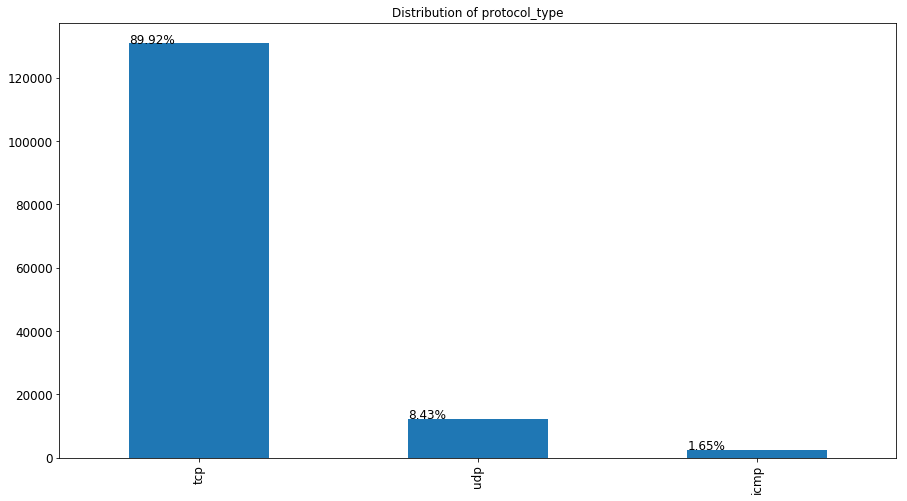

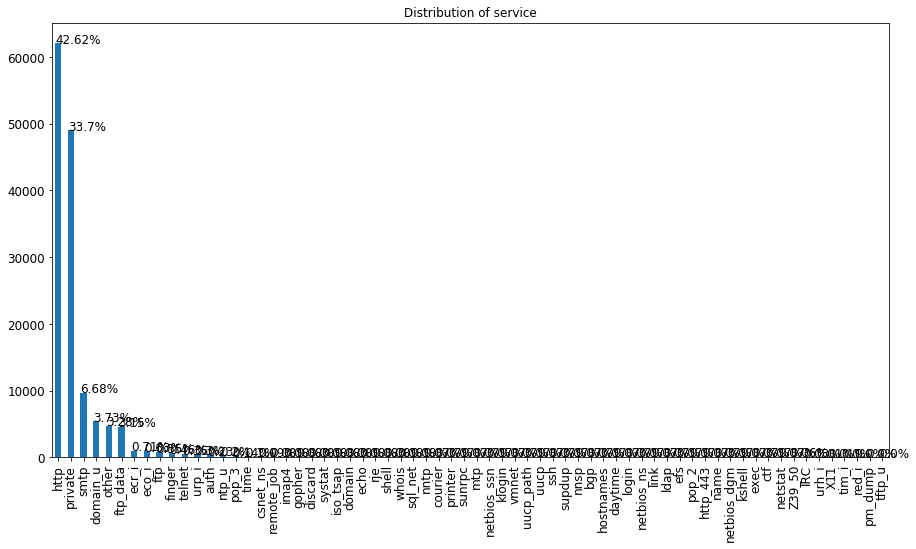

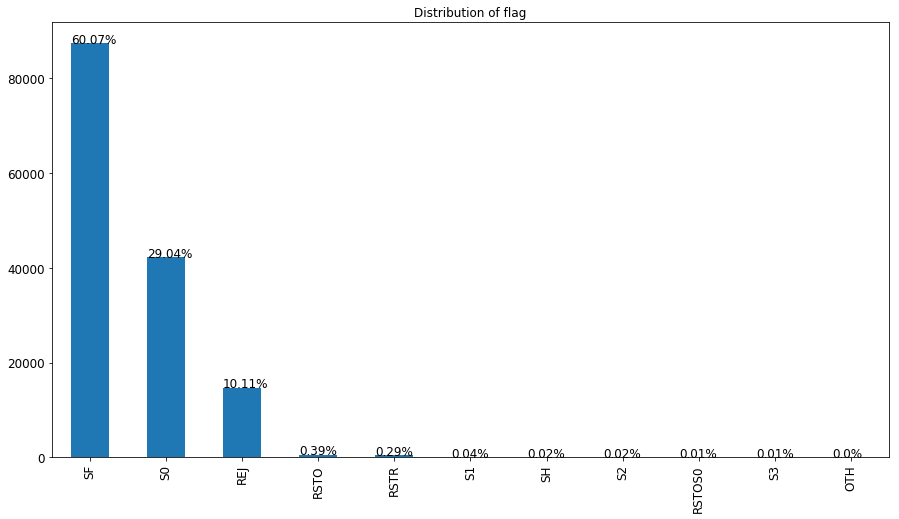

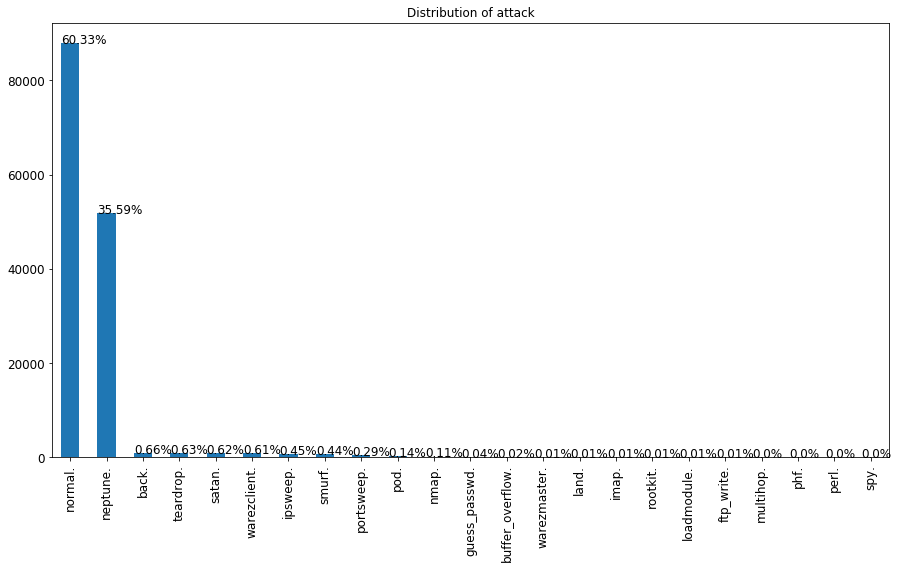

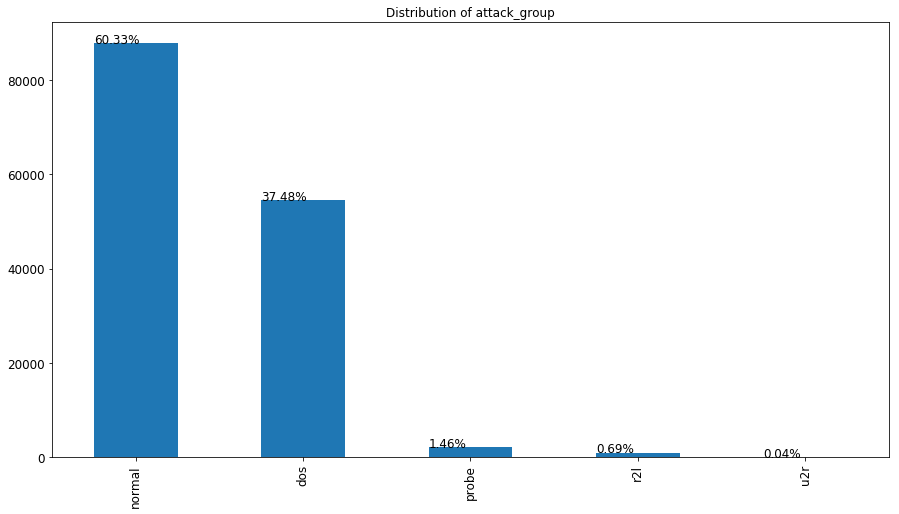

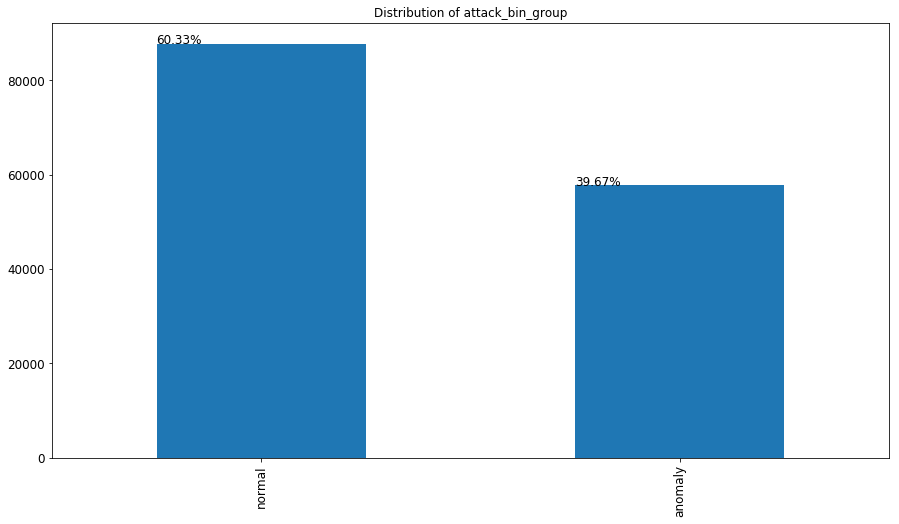

In [24]:
for column in cat_features:
    plot_column_distribution(df_train, column)

<b> Observations: </b>

- protocol type: 
    - Most of the connections (89.92%) use the protocol "tcp"
- flag:

    - Flag feature describes the status of the connection – Normal or Error and whether the flag was raised or not.
    - Each value in the flag feature represent a different scenario, we will use this feature AS IS.

- service:
    - Service column has 66 unique value, applying onehot encoding on this columns leads to new 66 columns. lets understand the importance of this column and try to bin if possible.

- label:
    - Most of the datapoints (60.33%) labeled normal as normal connection and the rest 39.67 % as bad connections.
    - In the category of bad connections neptune tops it with 35.59%.
    - The categories rootkit, loadmodule, ftp_write,multihop, phf, perl, and spy have very few data points (=<10).
    - In conlcusion, the dataset is very imbalaned, we should consider this data imbalnce while building the model to classify the datapoints righly to target lable without bias. 

##### <a> 3.2.1 Explore "service" column importance </a>

Lets see the influence of service column on target label.

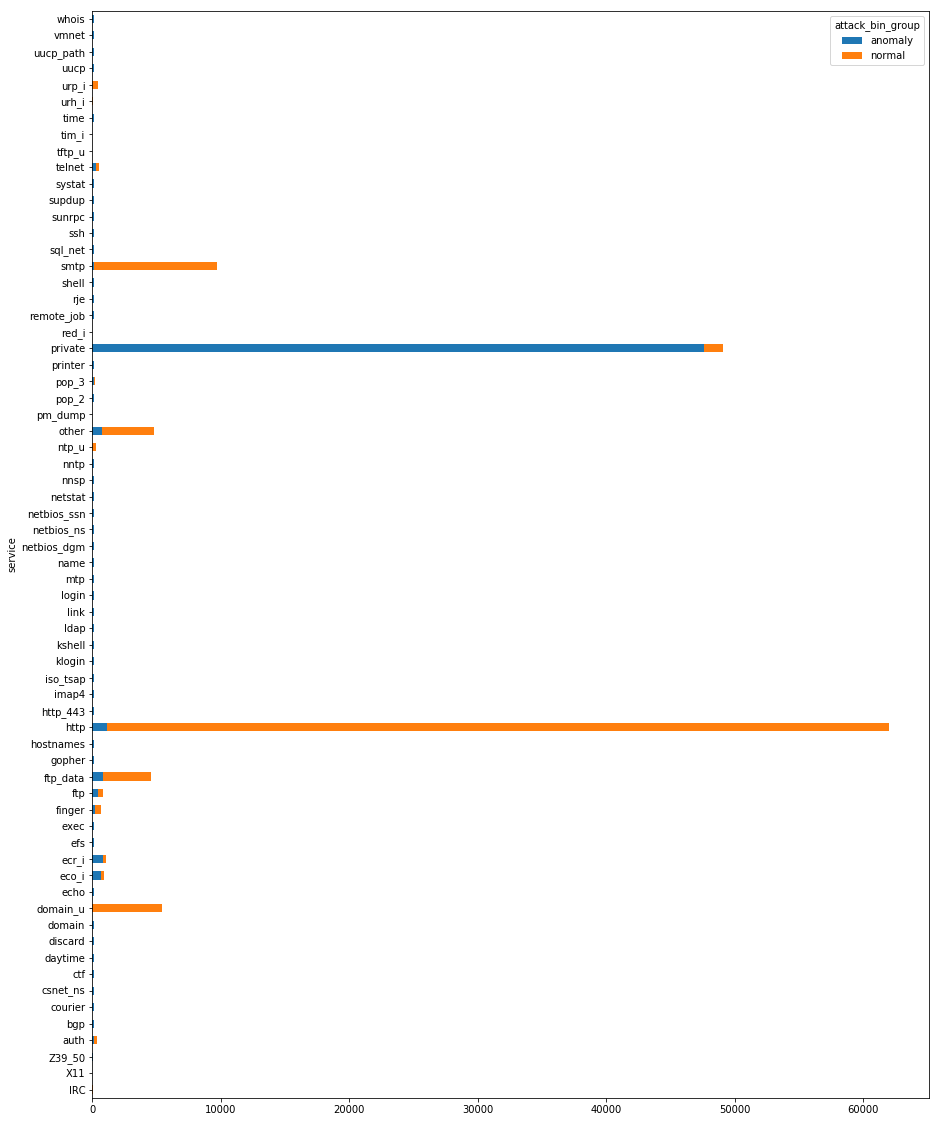

In [25]:
crosstab_service = pd.crosstab(df_train['service'], df_train['attack_bin_group'])
ax = crosstab_service.plot(kind='barh', stacked = True, figsize=(15, 20))

Normalized distribution of service column with overlay of target lable (anomoly vs normal)

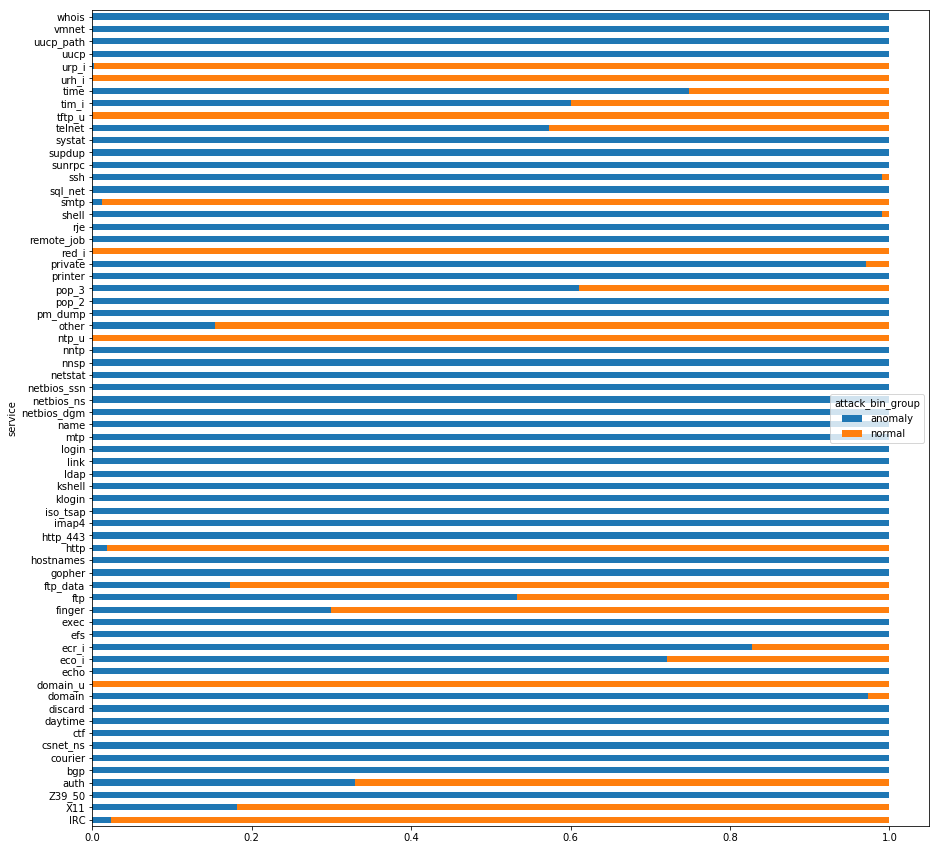

In [26]:
crosstab_service_norm = crosstab_service.div(crosstab_service.sum(1), axis = 0)
crosstab_service_norm.plot(kind='barh', stacked = True, figsize=(15, 15))

Cross tables representing numbers and percentages.

In [27]:
crosstab_service_tab = pd.crosstab(df_train['attack_bin_group'], df_train['service'])

In [28]:
crosstab_service_tab

service,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,printer,private,red_i,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois
attack_bin_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
anomaly,1,2,91,108,104,108,126,97,103,116,111,1,112,660,850,101,98,200,425,795,117,103,1171,99,117,115,106,98,101,102,103,107,98,98,102,107,95,105,108,0,734,1,101,122,108,47594,0,120,111,110,123,110,104,107,105,115,293,0,3,104,0,1,105,106,106,110
normal,42,9,0,220,0,0,0,0,0,0,3,5424,0,256,177,0,0,468,373,3797,0,0,60883,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,290,4035,0,0,78,0,1463,1,0,0,1,9598,0,1,0,0,0,219,1,2,35,14,442,0,0,0,0


In [29]:
round(crosstab_service_tab.div(crosstab_service_tab.sum(0), axis = 1)*100, 1)

service,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,printer,private,red_i,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois
attack_bin_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
anomaly,2.3,18.2,100.0,32.9,100.0,100.0,100.0,100.0,100.0,100.0,97.4,0.0,100.0,72.1,82.8,100.0,100.0,29.9,53.3,17.3,100.0,100.0,1.9,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,15.4,100.0,100.0,61.0,100.0,97.0,0.0,100.0,100.0,99.1,1.3,100.0,99.0,100.0,100.0,100.0,57.2,0.0,60.0,74.8,0.0,0.2,100.0,100.0,100.0,100.0
normal,97.7,81.8,0.0,67.1,0.0,0.0,0.0,0.0,0.0,0.0,2.6,100.0,0.0,27.9,17.2,0.0,0.0,70.1,46.7,82.7,0.0,0.0,98.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,84.6,0.0,0.0,39.0,0.0,3.0,100.0,0.0,0.0,0.9,98.7,0.0,1.0,0.0,0.0,0.0,42.8,100.0,40.0,25.2,100.0,99.8,0.0,0.0,0.0,0.0


<b>Observations</b>

- We see a few service categories (example: bgp, courier, csnet_ns etc...) represent only anomoly connections.
- In otherway, a few service categories (example: domain_u, ntp_u, red_i etc...) represent only normal connections.
- But there are service categories (example: auth, eco_i, ecr_i etc...) representing both normal and anomoly connections.
- The majority of connections belong to service category http (42.67%) followed by private (33.76%) and smtp (6.69%).

Based on the following observations, the service category can be categorized into following groups good, bad, and ambivalent. Incase of new categories, this look up needs to be updated.

In [30]:
services = ['IRC' ,'X11' ,'Z39_50' ,'auth' ,'bgp' ,'courier' ,'csnet_ns' ,'ctf' ,'daytime' ,'discard' ,'domain' ,
            'domain_u' ,'echo', 'eco_i' ,'ecr_i' ,'efs' ,'exec' ,'finger' ,'ftp' ,'ftp_data' ,'gopher' ,'hostnames',
            'http' ,'http_443' ,'imap4' ,'iso_tsap', 'klogin' ,'kshell' ,'ldap' ,'link' ,'login' ,'mtp' ,'name',
            'netbios_dgm' ,'netbios_ns' ,'netbios_ssn' ,'netstat' ,'nnsp', 'nntp' ,'ntp_u' ,'other' ,'pm_dump',
            'pop_2' ,'pop_3' ,'printer' ,'private' ,'red_i' ,'remote_job' ,'rje' ,'shell' ,'smtp', 'sql_net','ssh',
            'sunrpc' ,'supdup' ,'systat' ,'telnet' ,'tftp_u' ,'tim_i' ,'time' ,'urh_i' ,'urp_i' ,'uucp','uucp_path',
            'vmnet' ,'whois']

In [31]:
x_services = ['ambivalent' ,'ambivalent', 'bad', 'ambivalent', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'ambivalent',
              'good', 'bad', 'ambivalent', 'ambivalent', 'bad', 'bad', 'ambivalent', 'ambivalent', 'ambivalent', 
              'bad', 'bad', 'ambivalent', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 
              'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'good', 'ambivalent', 'bad', 'bad', 'ambivalent', 'bad',
              'ambivalent', 'good', 'bad', 'bad', 'ambivalent', 'ambivalent', 'bad', 'bad', 'bad', 'bad', 'bad', 
              'ambivalent', 'good', 'ambivalent', 'ambivalent', 'good', 'ambivalent', 'bad', 'bad', 'bad', 'bad']

service_mapping = {}
for service, X_service in zip(services, x_services):
    service_mapping[service]=X_service

# incase of missing mapping, the catgeory is mapped to ambivalent
df_train['X_service'] = df_train.service.apply(lambda val: service_mapping.get(val, 'ambivalent'))
df_test['X_service'] = df_test.service.apply(lambda val: service_mapping.get(val, 'ambivalent'))

In [32]:
df_train.X_service.value_counts()

ambivalent    135508
good            5731
bad             4347
Name: X_service, dtype: int64

In [33]:
df_test.X_service.value_counts()

ambivalent    68211
good           2684
bad            2374
Name: X_service, dtype: int64

#### <a> 3.3 Explore boolean features </a>

In [34]:
bool_features = df_train.columns[df_train.dtypes=='bool']

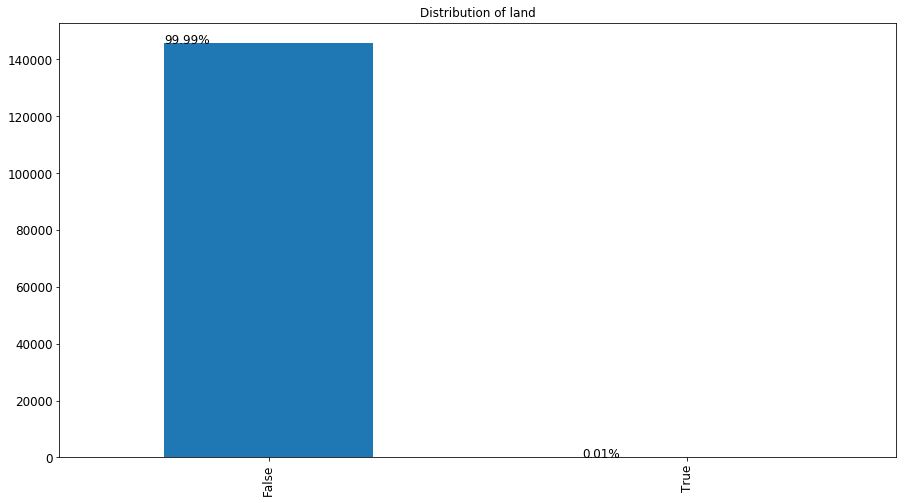

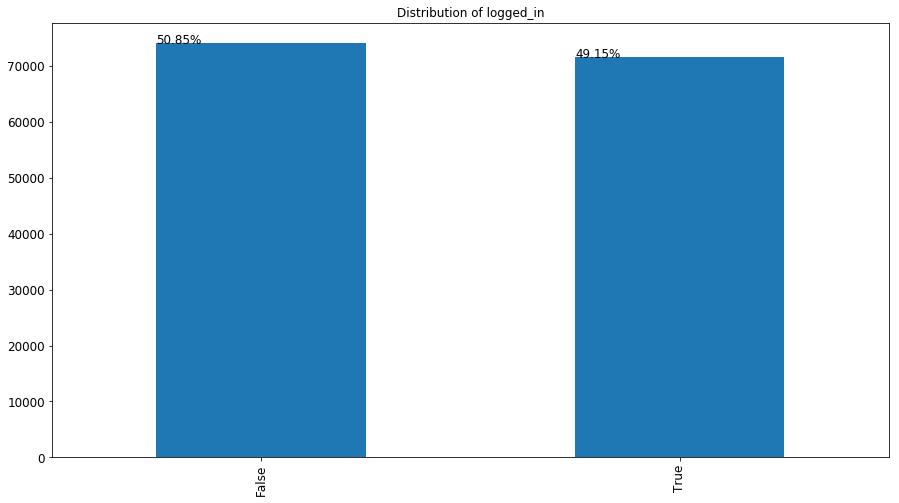

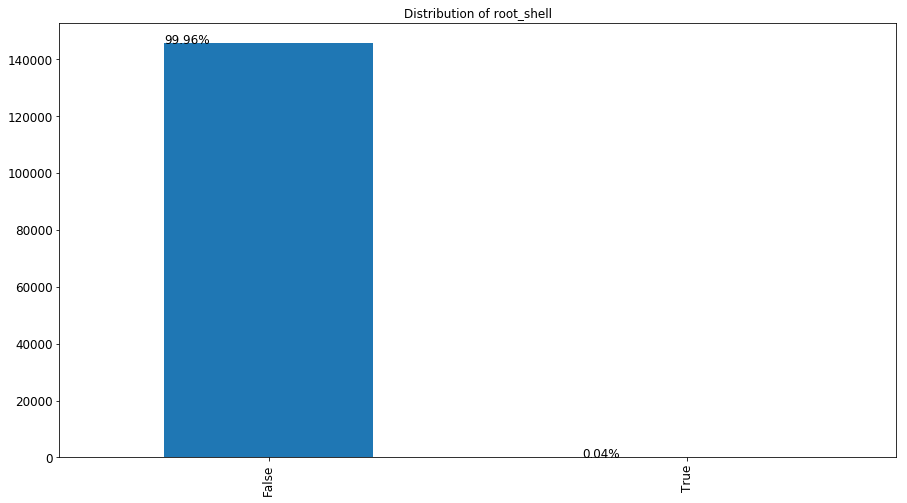

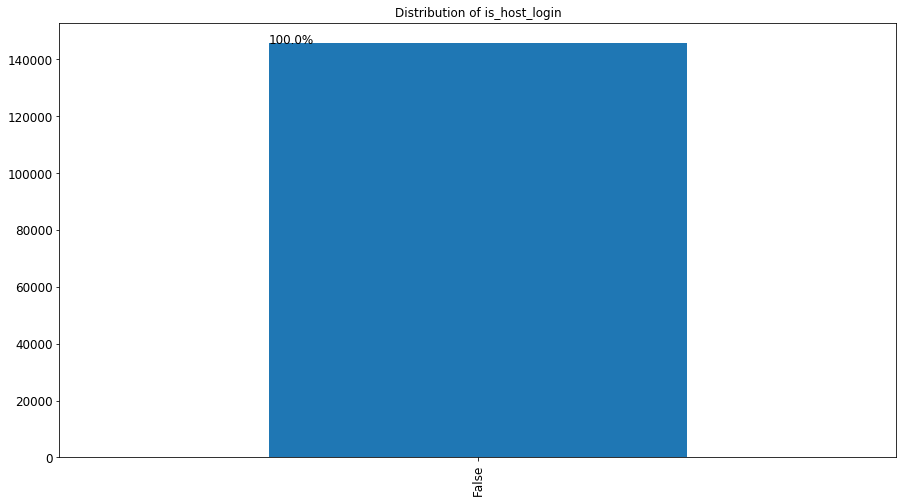

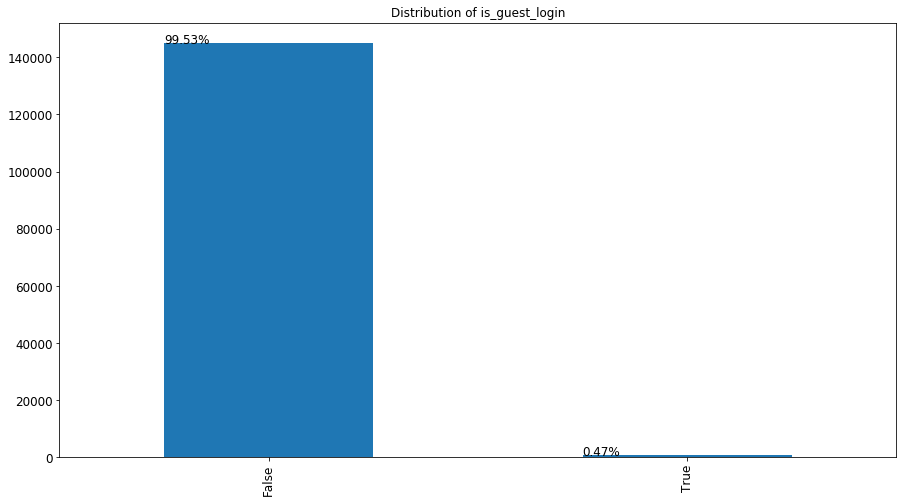

In [35]:
for column in bool_features:
    plot_column_distribution(df_train, column)

<b> Observations: </b>

- The feature <b> is_host_login </b> is constant so, we ingnore this column for both training and prediction.

#### <a> 3.4 Explore numerical features </a>

In [36]:
num_columns = df_train.columns[(df_train.dtypes!='bool') & (df_train.dtypes!='object')]

In [37]:
df_train[num_columns].describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,145586.000000,1.455860e+05,1.455860e+05,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.0,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000,145586.000000
mean,132.025181,7.995700e+03,2.859780e+03,0.020201,0.000048,0.100174,0.000515,0.026177,0.000124,0.038520,0.003675,0.000371,0.003414,0.0,74.385593,13.011464,0.291379,0.291551,0.108355,0.108412,0.655194,0.040576,0.093079,181.468177,129.934678,0.553222,0.061389,0.092825,0.019048,0.291597,0.290978,0.110463,0.107675
std,1224.157053,1.820383e+06,6.080979e+04,0.239368,0.010150,1.426798,0.028585,3.311373,0.014354,3.707494,0.177581,0.020298,0.067091,0.0,100.335945,30.736126,0.452903,0.453567,0.308961,0.308805,0.446795,0.120396,0.241952,99.098197,114.714829,0.456236,0.147021,0.241123,0.060410,0.452492,0.453447,0.306097,0.304220
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,78.000000,12.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.470000e+02,1.050000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,117.000000,0.770000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.880000e+02,1.164750e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,132.000000,15.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.030000,0.020000,1.000000,1.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,3.000000,3.000000,30.000000,5.000000,884.000000,2.000000,993.000000,28.000000,2.000000,8.000000,0.0,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### <a> 3.4.1 Features with zero variance </a>

Find the features with zero variance since these feartures will not help the model learn the characteristics of the problem.

In [38]:
df_train[num_columns].describe().transpose()[df_train[num_columns].describe().transpose()['std'] <= 0]

,count,mean,std,min,25%,50%,75%,max
num_outbound_cmds,145586.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<b> Observations </b>

- The feature <b> num_outbound_cmds </b> has zero variance, it takes constant value. 
- We will not consider "num_outbound_cmds" feature for both training and prediction.

#### <a> 3.4.2 Features with high variance variance </a>

Find the features with high variance.

In [39]:
df_train[num_columns].describe().transpose().sort_values('std', ascending=False).head(8)

,count,mean,std,min,25%,50%,75%,max
src_bytes,145586.0,7995.699628,1.820383e+06,0.0,0.0,147.0,288.00,693375640.0
dst_bytes,145586.0,2859.780020,6.080979e+04,0.0,0.0,105.0,1164.75,5155468.0
duration,145586.0,132.025181,1.224157e+03,0.0,0.0,0.0,0.00,58329.0
dst_host_srv_count,145586.0,129.934678,1.147148e+02,0.0,12.0,117.0,255.00,255.0
count,145586.0,74.385593,1.003359e+02,0.0,2.0,12.0,132.00,511.0
dst_host_count,145586.0,181.468177,9.909820e+01,0.0,78.0,255.0,255.00,255.0
srv_count,145586.0,13.011464,3.073613e+01,0.0,2.0,8.0,15.00,511.0
num_root,145586.0,0.038520,3.707494e+00,0.0,0.0,0.0,0.00,993.0


<b> Observations </b>
- src_bytes, dst_bytes, and count seems to have variance but we cannot draw any conclusion out from this analysis, may be good idea to exclude these columns during modeling.
- Atleast, we don't find any unique identifiers since the unique values (uuid) will have high variance.

#### <a> 3.4.3 Explore the correlation amonth features </a>

Plot the correlation matrix among numerical features.

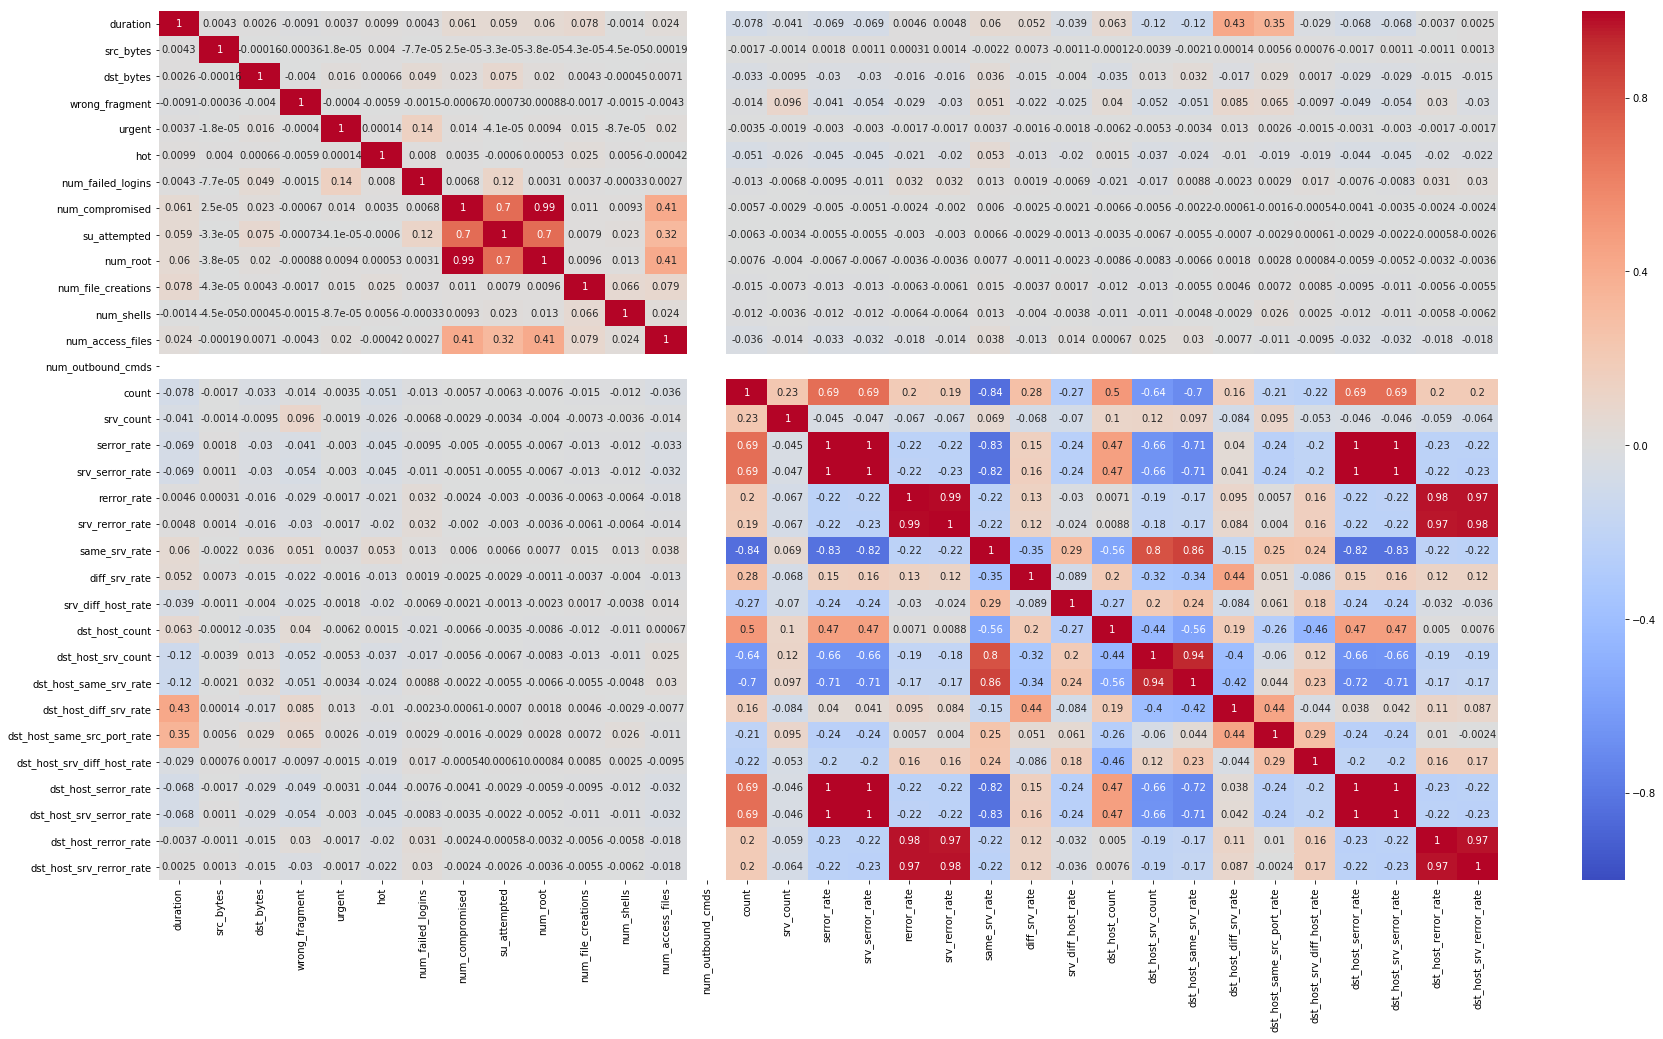

In [40]:
plt.figure(figsize=(30, 16))
sns.heatmap(df_train[num_columns].corr(), vmin=-1,  cmap='coolwarm',annot=True)

<b> Observations </b>
- The feature <b> serror_rate </b> is highly correlated with <b>dst_host_srv_serror_rate, dst_host_serror_rate, and srv_serror_rate</b>.
- The feature <b> srv_serror_rate </b> is highly correlated with <b>dst_host_srv_serror_rate, dst_host_serror_rate, and serror_rate</b>.
- The feature <b> rerror_rate </b> is highly correlated with <b>dst_host_srv_rerror_rate, dst_host_rerror_rate, and srv_rerror_rate</b>.
- The feature <b> srv_rerror_rate </b> is highly correlated with <b>dst_host_srv_rerror_rate, dst_host_rerror_rate, and rerror_rate</b>.
- The feature <b> dst_host_srv_count </b> is highly correlated with <b>dst_host_same_srv_rate</b>.
- The feature <b> num_compromised </b> is highly correlated with <b>num_root</b>.
- We will not consider the features <b> rerror_rate </b>, <b> srv_rerror_rate </b>, <b> serror_rate </b>, and <b> srv_serror_rate </b> for training and prediction.
- We will not consider the features <b> dst_host_serror_rate </b>, and <b> dst_host_rerror_rate </b> for training and prediction.
- We will not consider the features <b> dst_host_same_srv_rate </b> for training and prediction.
- We will not consider the feature <b>num_root</b> for training and prediction.

The following are the <b> descriptions </b> of the few features relavant to the correlated features.
- <i>count</i>: 
    - Number of connections to the same destination host as the current connection in the past two seconds
- <i>srv_count</i>: 
    - Number of connections to the same service (port number) as the current connection in the past two seconds
- <i>serror_rate</i>: 
    - The percentage of connections that have activated the flag (4) s0, s1, s2 or s3, among the connections aggregated in count 
- <i>srv_serror_rate</i>: 
    - The percentage of connections that have activated the flag (4) s0, s1, s2 or s3, among the connections aggregated in srv_count.
- <i>rerror_rate</i>: 
    - The percentage of connections that have activated the flag (4) REJ, among the connections aggregated in count.
- <i>srv_rerror_rate</i>: 
    - The percentage of connections that have activated the flag (4) REJ, among the connections aggregated in srv_count.

- <i>dst_host_count</i>: 
    - Number of connections having the same destination host IP address
- <i>dst_host_srv_count</i>: 
    - Number of connections having the same port number
- <i>dst_host_serror_rate</i>: 
    - The percentage of connections that have activated the flag (4) s0, s1, s2 or s3, among the connections aggregated in dst_host_count.
- <i>dst_host_rerror_rate</i>: 
    - The percentage of connections that have activated the flag (4) REJ, among the connections aggregated in dst_host_count.

- <i> dst_host_same_srv_rate </i>: 
    - The percentage of connections that were to different services, among the connections aggregated in dst_host_count.
- <i> num_root </i>: 
    - Number of "root'' accesses or number of operations performed as a root in the connection

Plot the correlation matrix among numerical features after removing highly correlated columns.

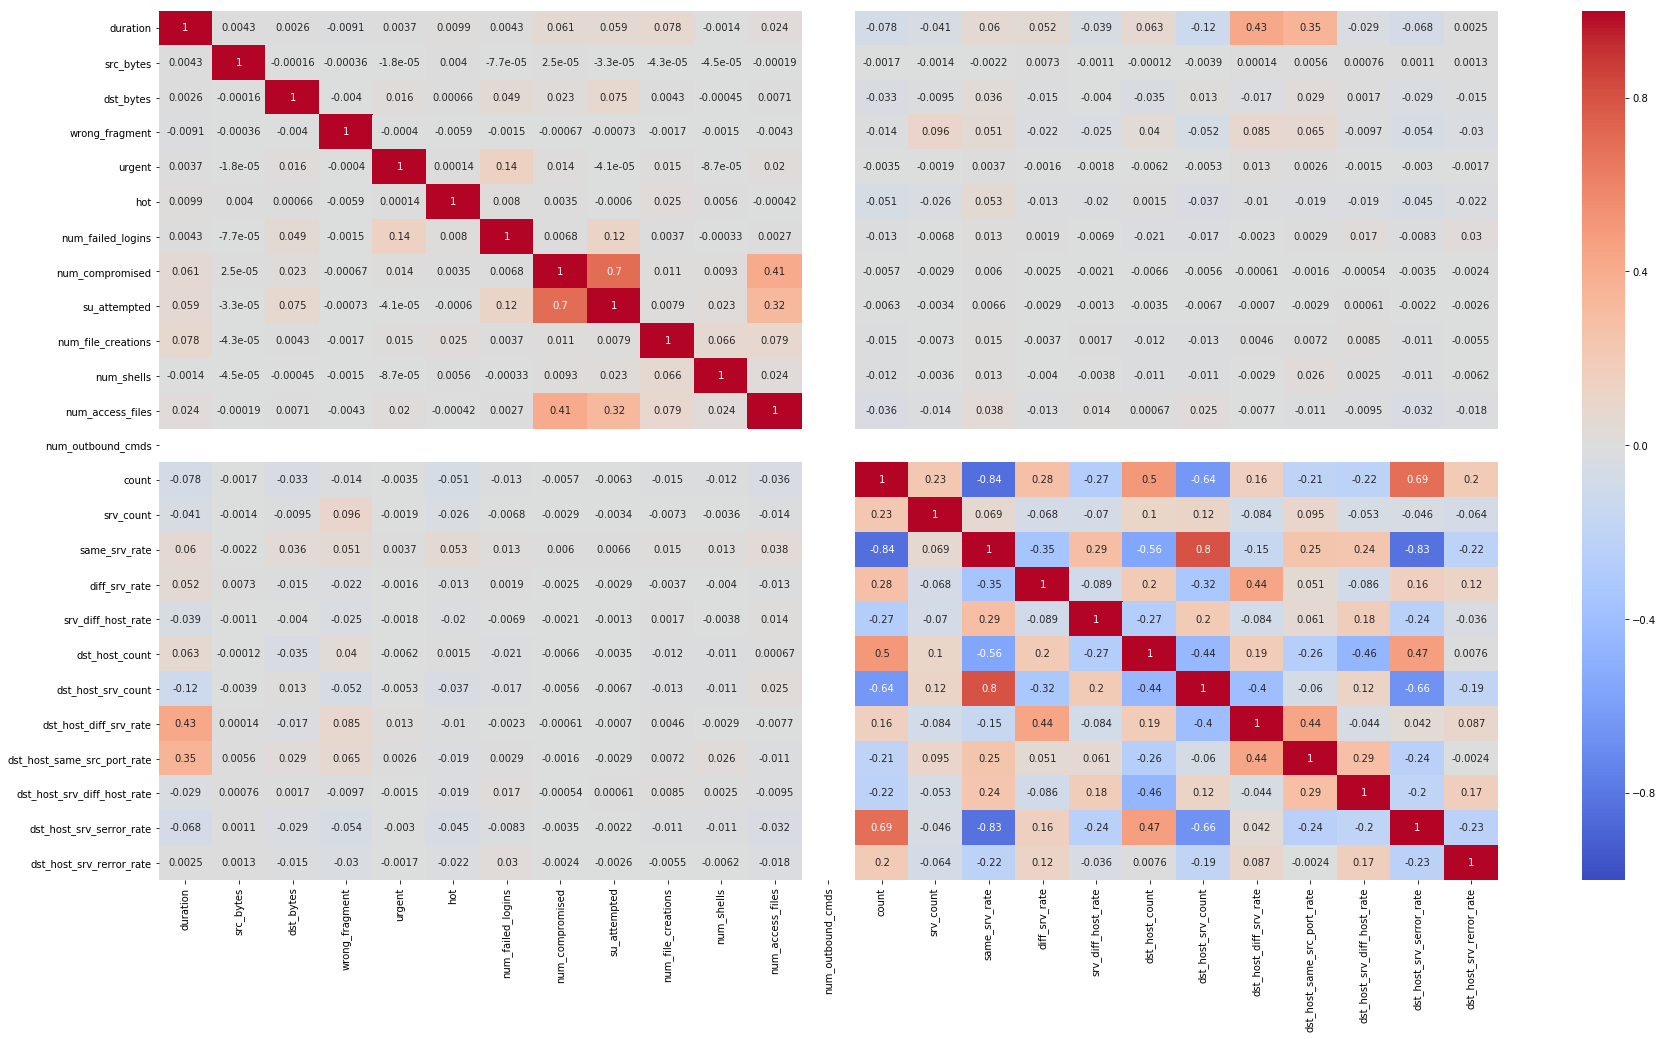

In [41]:
plt.figure(figsize=(30, 16))
fil_num_columns = [col for col in num_columns if col not in 
                   ['serror_rate','srv_serror_rate', 'rerror_rate','srv_rerror_rate',
                    'dst_host_serror_rate', 'dst_host_rerror_rate', 'dst_host_same_srv_rate','num_root']]
sns.heatmap(df_train[fil_num_columns].corr(), vmin=-1,  cmap='coolwarm',annot=True)

#### <a> 3.4.4 Explore distribution of features </a>

In [42]:
def plot_histograms(dataframe, features, rows, cols, log1p=False):
    fig=plt.figure(figsize=(30,30))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        if log1p:
            dataframe[feature].hist(log=True, bins=20,ax=ax,facecolor='green')
        else:
            dataframe[feature].hist(bins=20,ax=ax,facecolor='green')
        ax.set_title(feature+" Distribution",color='red')
    fig.tight_layout()
    plt.show()

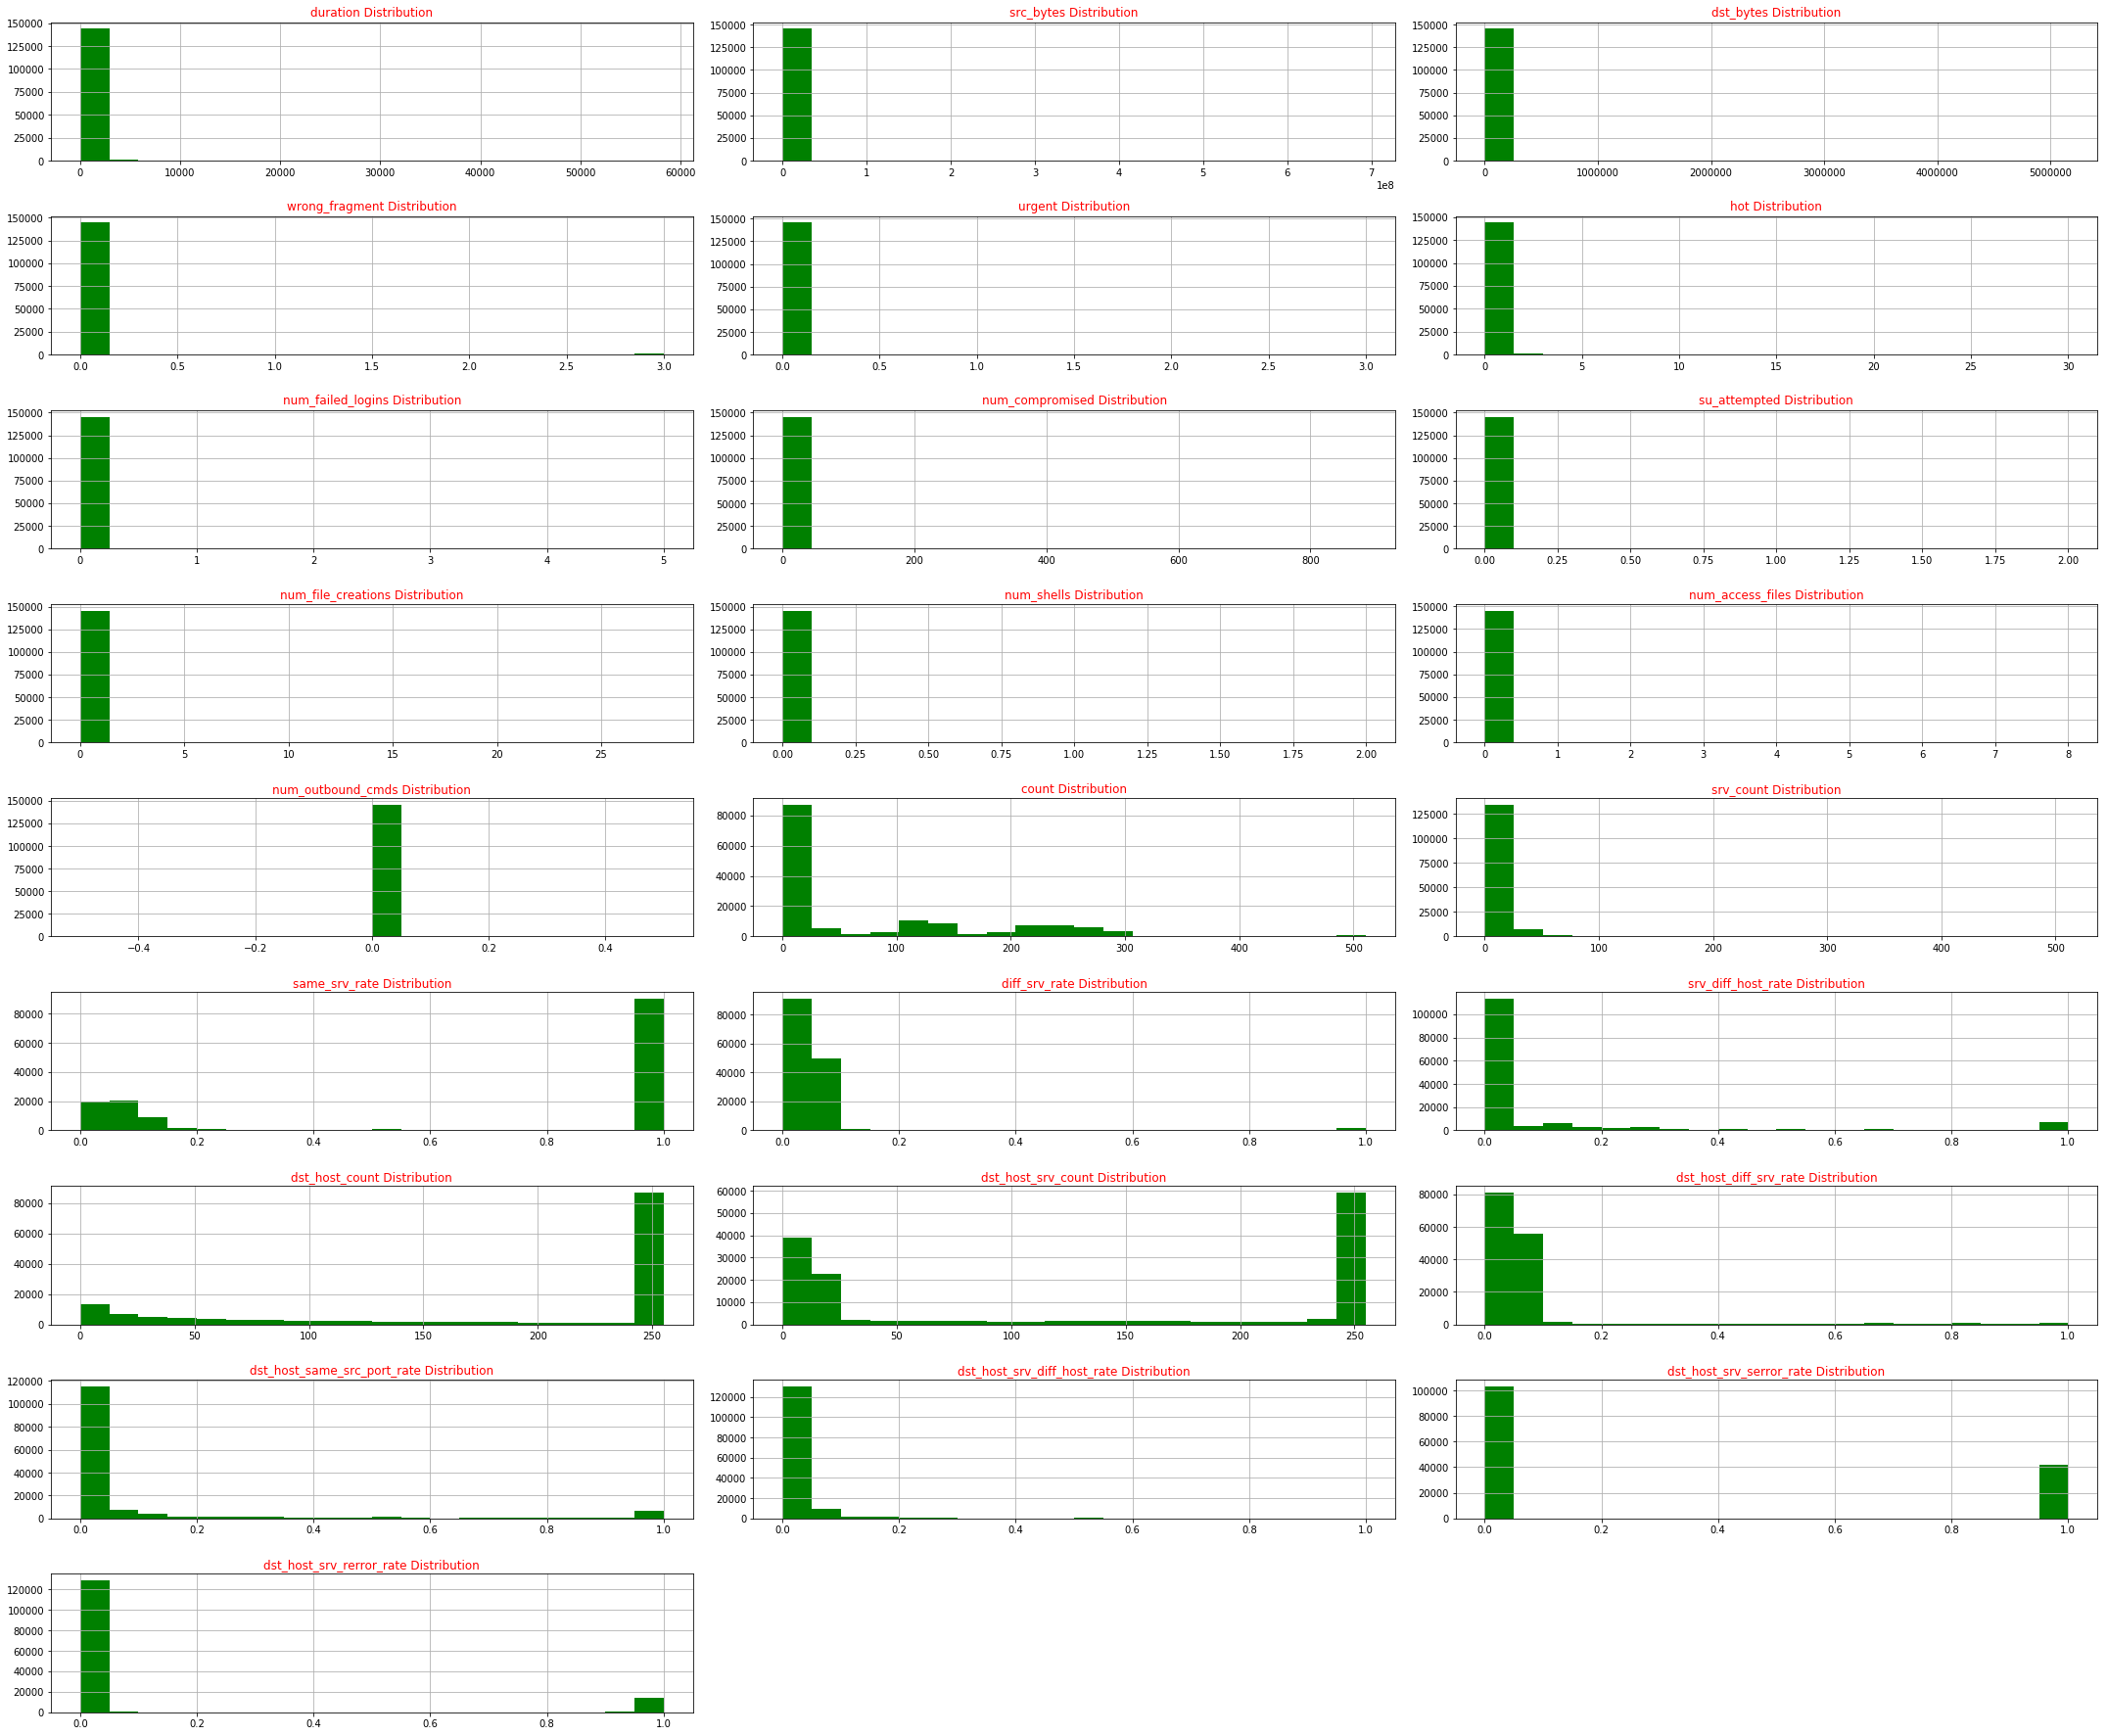

In [43]:
plot_histograms(df_train,fil_num_columns,11,3)

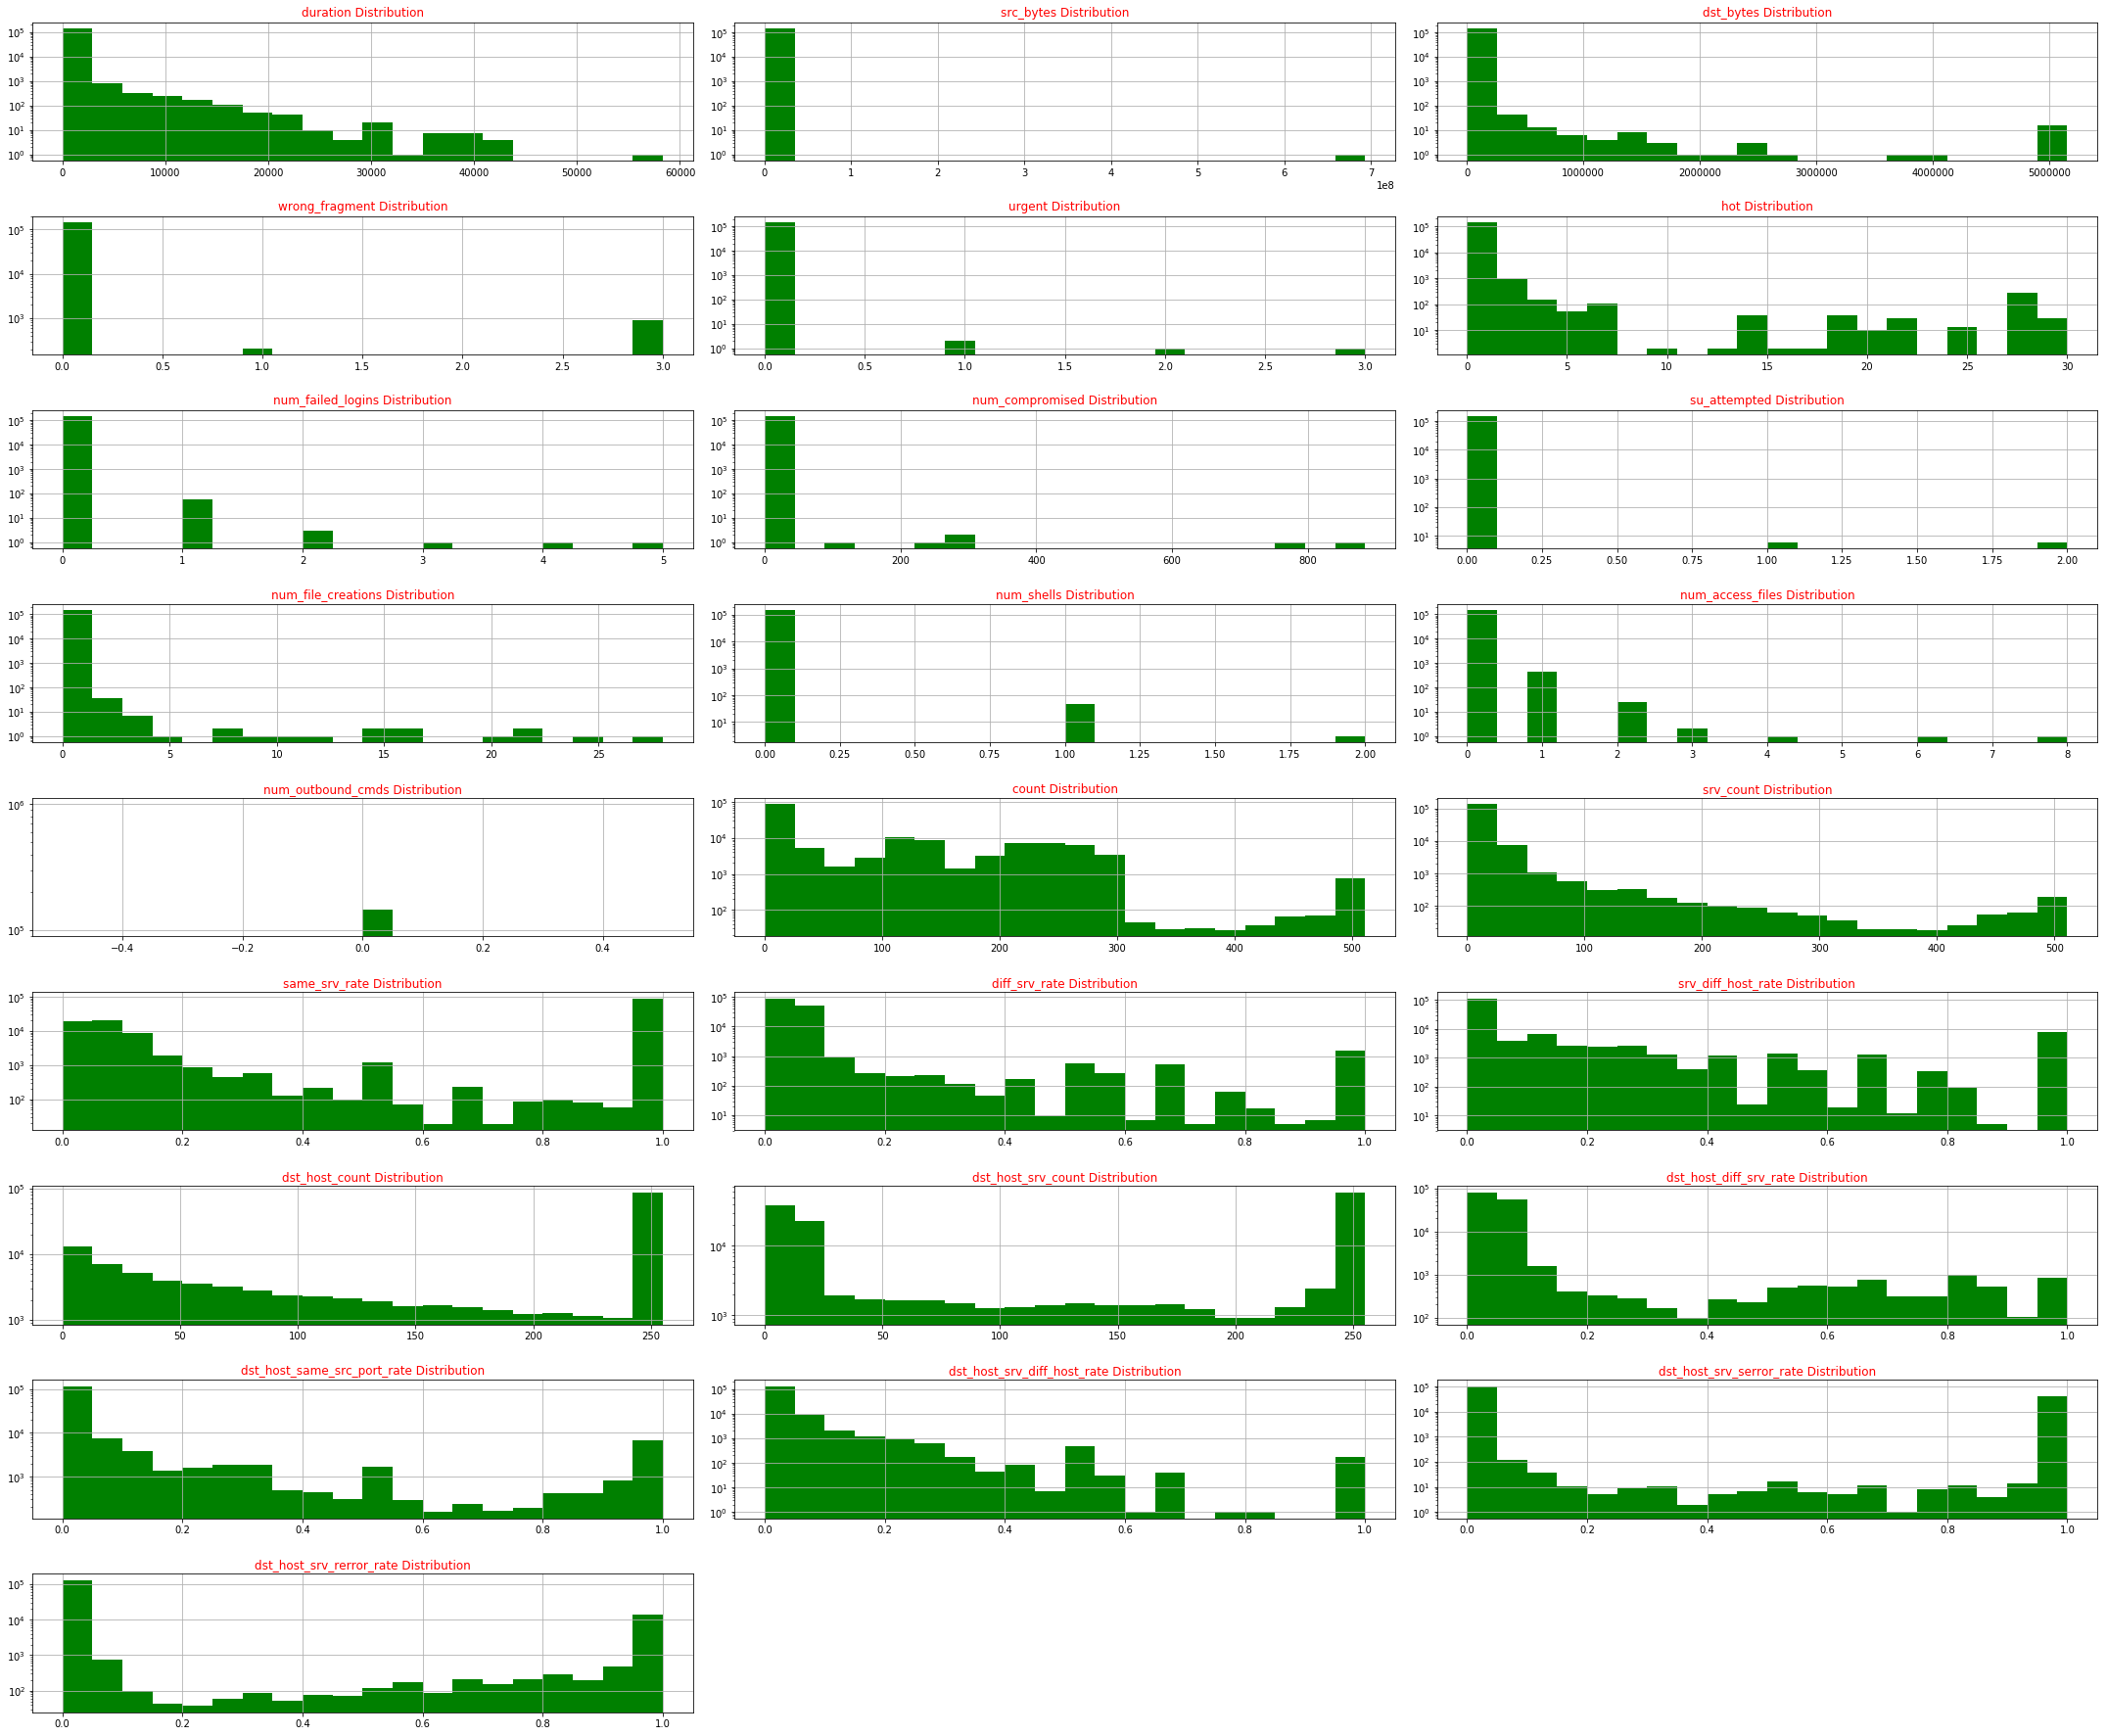

In [44]:
plot_histograms(df_train,fil_num_columns,11,3, True)

<b> Observations: </b>

- The following plots do not give us any clear and satisfactory results.
- We will scale the features while modeling.
- Below are the following options to proceed further with exploratory analysis.
    - Linear subspace mechanisms (PCA/tSNE).

#### <a> 3.4.5 Univariate analysis (target label vs duration) </a>

Lets do further analysis to bin the numerical variables (here, duaration) by plotting historgrams with label overlay.

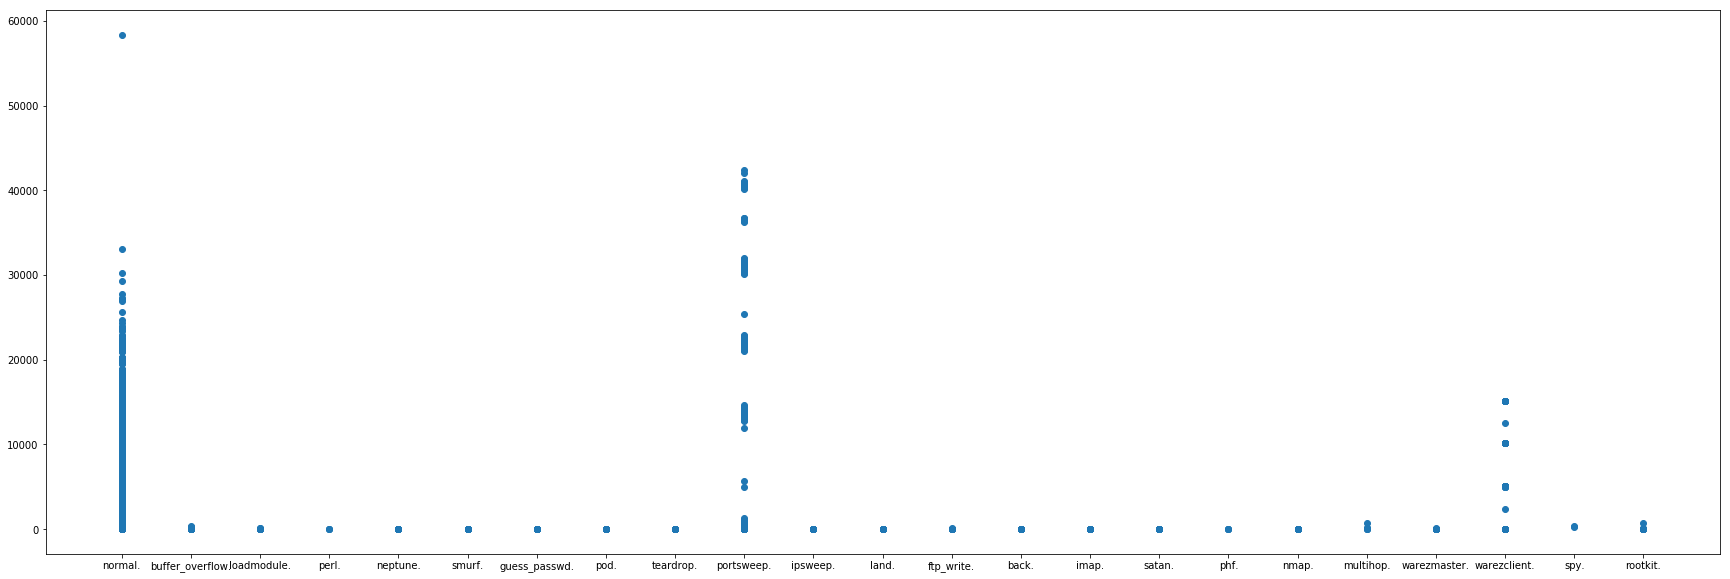

In [45]:
plt.figure(figsize=(30, 10))
plt.scatter(df_train['attack'], df_train['duration'])

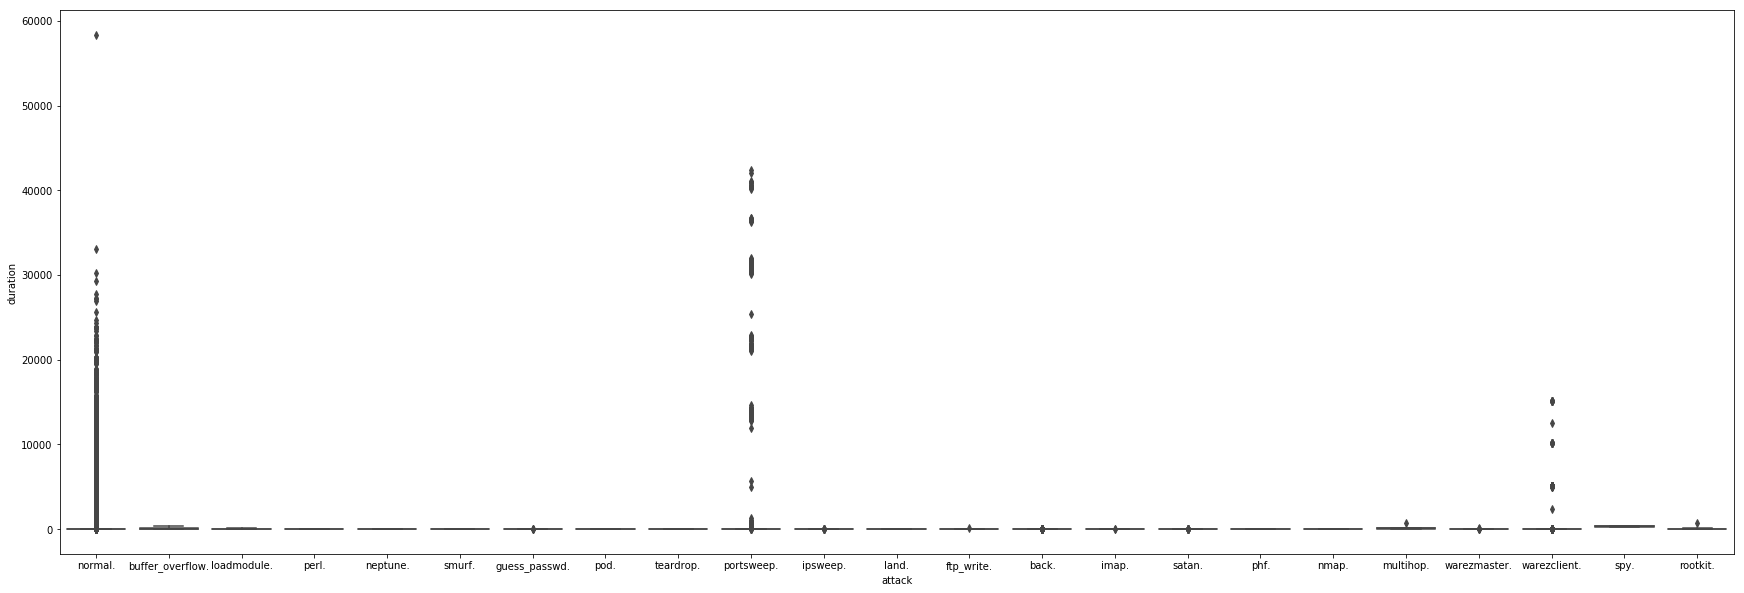

In [46]:
plt.figure(figsize=(30, 10))
sns.boxplot(df_train['attack'], df_train['duration'])

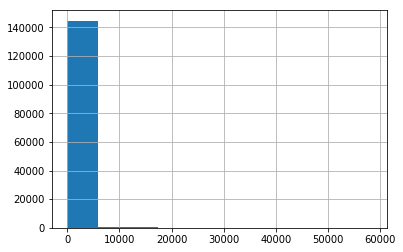

In [47]:
df_train['duration'].hist(log=False)

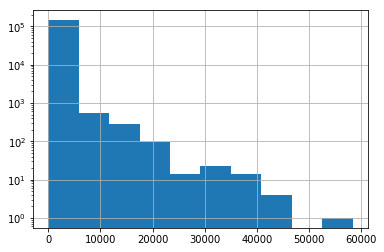

In [48]:
df_train['duration'].hist(log=True)

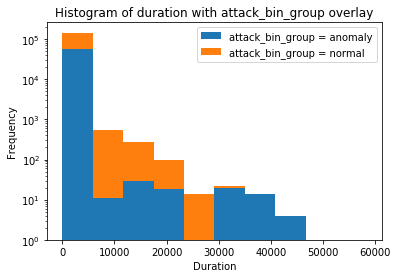

In [49]:
bt_duration_anomaly = df_train[df_train.attack_bin_group == "anomaly"]['duration']
bt_duration_normal = df_train[df_train.attack_bin_group == "normal"]['duration']
(n, bins, patches) = plt.hist([bt_duration_anomaly, bt_duration_normal], bins = 10, stacked = True, log=True) 
plt.legend(['attack_bin_group = anomaly', 'attack_bin_group = normal'], loc='best') 
plt.title('Histogram of duration with attack_bin_group overlay') 
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.show()

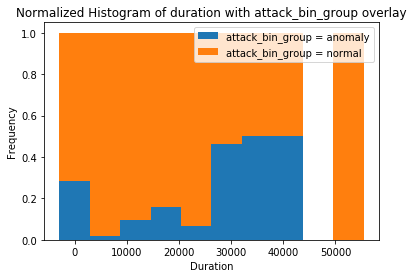

In [50]:
n_table = np.column_stack((n[0], n[1]))
n_norm = n_table / n_table.sum(axis=1)[:, None]
ourbins = np.column_stack((bins[0:10], bins[1:11]))

p1 = plt.bar(x = ourbins[:,0], height = n_norm[:,0], width = ourbins[:, 1]-ourbins[:, 0])
p2 = plt.bar(x = ourbins[:,0], height = n_norm[:,1], width = ourbins[:, 1]-ourbins[:, 0], bottom = n_norm[:,0])
plt.legend(['attack_bin_group = anomaly', 'attack_bin_group = normal'], loc='best') 
plt.title('Normalized Histogram of duration with attack_bin_group overlay') 
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.show()

<b>Observations</b>
- We cannot draw concrete conclusions based on the scatter plot or box plots.
- By looking at the normalized historogram of duration, we can say that anomaly rate is propotional to duration.
- Creating a binary variable is most suitable for alogorith but there is also anomaly spike around duration zero so, we dont create a new variable.
- As a next step, we can try analyzing the multiple combinations at the same time (bivariate/pairplot analysis)

### <a> 4. Modeling </a>

Metrics to evaluate the models.

- Confusion matrix
- Precision
- Recall
- F1-score (weighted incase of multiclass) 
- FPR 
    - We need false positive rate to be low since classifiying bad (attack) connection as normal connection (which may lead to security threat) is more costlier than classifying normal connection as bad (which may lead to lost connection)

- TPR (True Positive Rate)
    - Total number of points correctly classified as "bad" / Total number of points actually belongs to class "bad"

- FPR (False Positive Rate)
    - Total number of points incorrectly classified as "bad" / Total number of points actually belongs to class "normal"

#### <a>4.1 Binary classification </a>

##### <a>4.1.1 Prepare train and test Data sets </a>

In [51]:
exclude_features = ['num_outbound_cmds', 'rerror_rate', 'srv_rerror_rate', 'serror_rate', 'srv_serror_rate',
                    'dst_host_serror_rate', 'dst_host_rerror_rate', 'is_host_login','dst_host_same_srv_rate',
                    'num_root', 'service','attack']
include_features = ['X_service']

X_features = [feature for feature in cnames if feature not in exclude_features] + include_features
y_feature = ['attack_bin_group']

X_train = df_train[X_features]
y_train = df_train[y_feature]
X_test = df_test[X_features]
y_test = df_test[y_feature]

numerical_features = X_train.select_dtypes(exclude=['object','category','bool']).columns.tolist()

##### <a>4.1.2 Encode target label </a>

In [52]:
y_train_bin = y_train.replace(to_replace=['normal','anomaly'], value=[0,1])
y_test_bin = y_test.replace(to_replace=['normal','anomaly'], value=[0,1])

##### <a>4.1.3 Scale the numerical features </a>

Scaling the training and test features to improve the performance and also brings the feature scale further close to each other.

In [53]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features]= scaler.transform(X_test[numerical_features])

##### <a>4.1.4 Create dummies for categorical features </a>

In [54]:
X_train_dummies= pd.get_dummies(X_train)
X_test_dummies= pd.get_dummies(X_test)
X_train_dummies.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_file_creations,num_shells,num_access_files,is_guest_login,count,srv_count,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_srv_serror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,X_service_ambivalent,X_service_bad,X_service_good
0,-0.10785,-0.004293,0.042596,False,-0.084394,-0.004737,-0.07021,-0.018022,True,-0.007905,False,-0.008613,-0.020694,-0.018274,-0.050883,False,-0.661635,-0.163049,0.771735,-0.337021,-0.384703,-1.740383,-1.054224,-0.417555,0.071230,-0.31531,-0.641705,-0.353941,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,-0.10785,-0.004261,-0.039036,False,-0.084394,-0.004737,-0.07021,-0.018022,True,-0.007905,False,-0.008613,-0.020694,-0.018274,-0.050883,False,-0.661635,-0.163049,0.771735,-0.337021,-0.384703,-1.639472,-0.967051,-0.417555,-0.177606,-0.31531,-0.641705,-0.353941,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,-0.10785,-0.004263,-0.025042,False,-0.084394,-0.004737,-0.07021,-0.018022,True,-0.007905,False,-0.008613,-0.020694,-0.018274,-0.050883,False,-0.661635,-0.163049,0.771735,-0.337021,-0.384703,-1.538562,-0.879878,-0.417555,-0.260552,-0.31531,-0.641705,-0.353941,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,-0.10785,-0.004272,-0.025042,False,-0.084394,-0.004737,-0.07021,-0.018022,True,-0.007905,False,-0.008613,-0.020694,-0.018274,-0.050883,False,-0.681569,-0.228119,0.771735,-0.337021,-0.384703,-1.437651,-0.792705,-0.417555,-0.260552,-0.31531,-0.641705,-0.353941,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,-0.10785,-0.004273,-0.013613,False,-0.084394,-0.004737,-0.07021,-0.018022,True,-0.007905,False,-0.008613,-0.020694,-0.018274,-0.050883,False,-0.681569,-0.228119,0.771735,-0.337021,-0.384703,-1.336741,-0.705532,-0.417555,-0.302025,-0.31531,-0.641705,-0.353941,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


##### <a> 4.1.5 Logistic Regression </a>

In [55]:
def grid_search_cv(X, y):
    """ Function to do grid search for logistic regresison """
    tuned_parameters = {"C":np.logspace(-6, 3, 10)}
    clf = LogisticRegression(solver='lbfgs', random_state=42, max_iter=1000, class_weight='balanced', verbose=0)
    logreg_cv = GridSearchCV(clf, tuned_parameters, cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                             return_train_score=True)
    logreg_cv.fit(X,y)
    return logreg_cv.best_params_, logreg_cv.best_score_, logreg_cv.best_estimator_, logreg_cv.cv_results_

In [56]:
start_time = time.time()
best_params, best_score, best_model, cv_results = grid_search_cv(X_train_dummies, y_train_bin)
print("--- %s seconds ---" % (time.time() - start_time))

--- 229.25780415534973 seconds ---


In [57]:
print('best mean cross-validation score: {:.3f}'.format(best_score))
print('best params: {}'.format(best_params))
print('test-set score: {:.3f}'.format(best_model.score(X_test_dummies, y_test_bin)))

best mean cross-validation score: 0.991
best params: {'C': 1000.0}
test-set score: 0.954


C is very high (low regularization) so, the model is complex and there is possibility of overfit. Yet, based on the performance the scores seems good on both train and test data set.

In [58]:
y_pred = best_model.predict(X_test_dummies)
count_misclassified = (y_test_bin['attack_bin_group'] != y_pred).sum()
accuracy = metrics.accuracy_score(y_test_bin['attack_bin_group'], y_pred)
print('misclassified datapoints: {} \n'.format(count_misclassified))
print('accuracy: {:.3f} \n '.format(accuracy))
print('the classification report: \n {}'.format(classification_report(y_test_bin['attack_bin_group'], y_pred)))

misclassified datapoints: 3379 

accuracy: 0.954 
 
the classification report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     47913
           1       0.97      0.90      0.93     25356

    accuracy                           0.95     73269
   macro avg       0.96      0.94      0.95     73269
weighted avg       0.95      0.95      0.95     73269



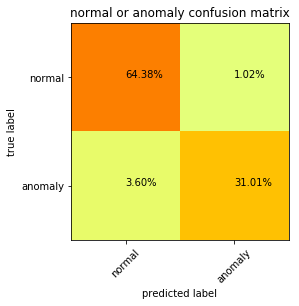

In [59]:
cm = confusion_matrix(y_test_bin['attack_bin_group'],y_pred)
obs = np.sum(cm)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['normal','anomaly']
plt.title('normal or anomaly confusion matrix')
plt.ylabel('true label')
plt.xlabel('predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str('{:.2f}'.format(cm[i][j]/obs*100)) + "%")
plt.show()

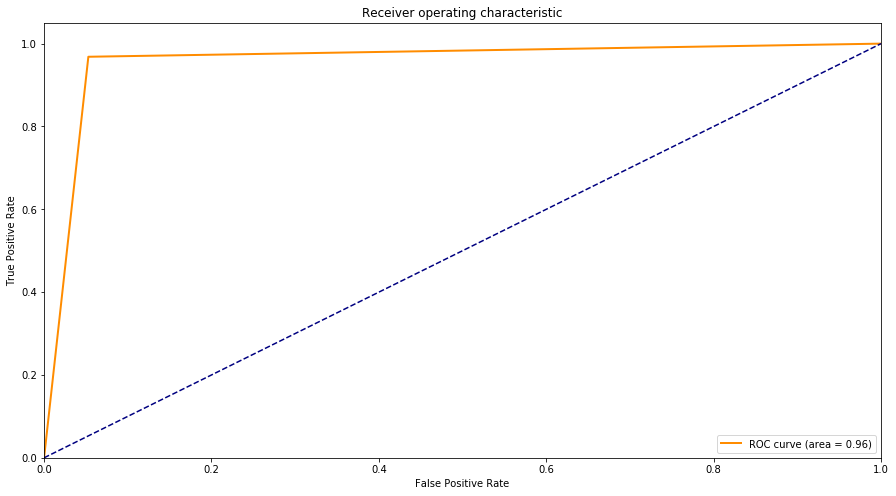

In [60]:
fpr, tpr, thresholds = roc_curve(y_pred, y_test_bin['attack_bin_group'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

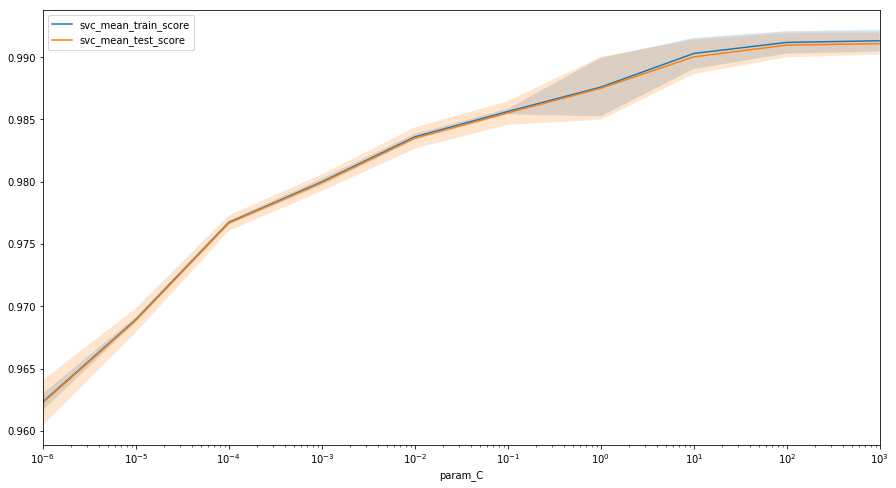

In [61]:
results_logit = pd.DataFrame(cv_results)
ax = results_logit.plot('param_C', 'mean_train_score', label='svc_mean_train_score', figsize=(15,8))
results_logit.plot('param_C', 'mean_test_score', ax=ax, label='svc_mean_test_score')
ax.fill_between(results_logit.param_C.astype(np.float),
                 results_logit['mean_train_score'] + results_logit['std_train_score'],
                 results_logit['mean_train_score'] - results_logit['std_train_score'], alpha=0.2)
ax.fill_between(results_logit.param_C.astype(np.float),
                 results_logit['mean_test_score'] + results_logit['std_test_score'],
                 results_logit['mean_test_score'] - results_logit['std_test_score'], alpha=0.2)

plt.legend(loc='best')
plt.xscale("log")

##### <a> 4.1.6 Linear SVC </a>

In [62]:
def grid_search_cv(X, y):
    """ Function to do grid search for svc regresison """
    tuned_parameters = {"C":[0.01, 0.1, 1, 10, 100]}
    clf = LinearSVC(verbose=0, max_iter=1000, class_weight='balanced')
    svc_cv = GridSearchCV(clf, tuned_parameters, cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                          return_train_score=True)
    svc_cv.fit(X,y)
    return svc_cv.best_params_, svc_cv.best_score_, svc_cv.best_estimator_, svc_cv.cv_results_

In [63]:
start_time = time.time()
best_params, best_score, best_model, cv_results = grid_search_cv(X_train_dummies, y_train_bin)
print("--- %s seconds ---" % (time.time() - start_time))

--- 22151.62080001831 seconds ---


In [64]:
print('best mean cross-validation score: {:.3f}'.format(best_score))
print('best params: {}'.format(best_params))
print('test-set score: {:.3f}'.format(best_model.score(X_test_dummies, y_test_bin)))

best mean cross-validation score: 0.990
best params: {'C': 10}
test-set score: 0.959


In [65]:
y_pred = best_model.predict(X_test_dummies)
count_misclassified = (y_test_bin['attack_bin_group'] != y_pred).sum()
accuracy = metrics.accuracy_score(y_test_bin['attack_bin_group'], y_pred)
print('misclassified datapoints: {} \n'.format(count_misclassified))
print('accuracy: {:.3f} \n '.format(accuracy))
print('the classification report: \n {}'.format(classification_report(y_test_bin['attack_bin_group'], y_pred)))

misclassified datapoints: 2969 

accuracy: 0.959 
 
the classification report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     47913
           1       0.97      0.91      0.94     25356

    accuracy                           0.96     73269
   macro avg       0.96      0.95      0.95     73269
weighted avg       0.96      0.96      0.96     73269



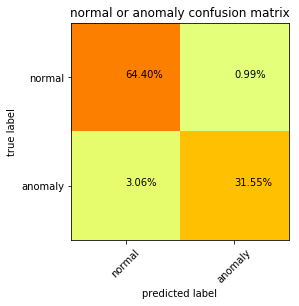

In [66]:
cm = confusion_matrix(y_test_bin['attack_bin_group'],y_pred)
obs = np.sum(cm)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['normal','anomaly']
plt.title('normal or anomaly confusion matrix')
plt.ylabel('true label')
plt.xlabel('predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str('{:.2f}'.format(cm[i][j]/obs*100)) + "%")
plt.show()

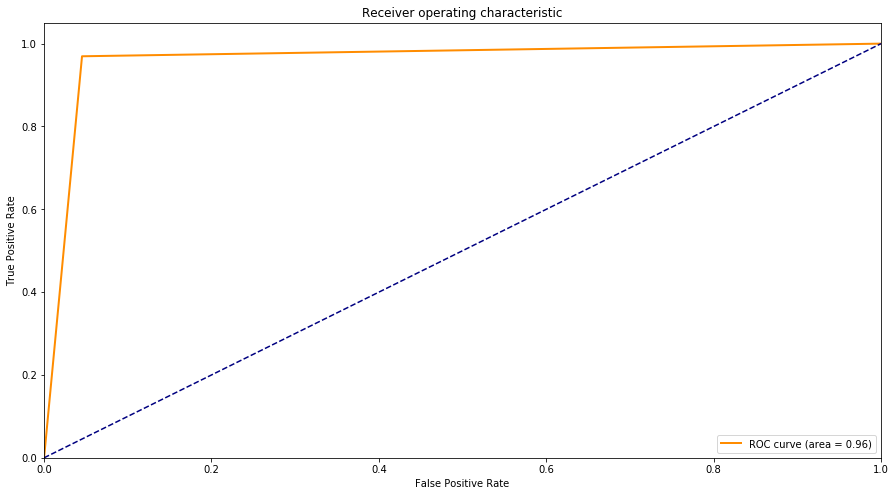

In [67]:
fpr, tpr, thresholds = roc_curve(y_pred, y_test_bin['attack_bin_group'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

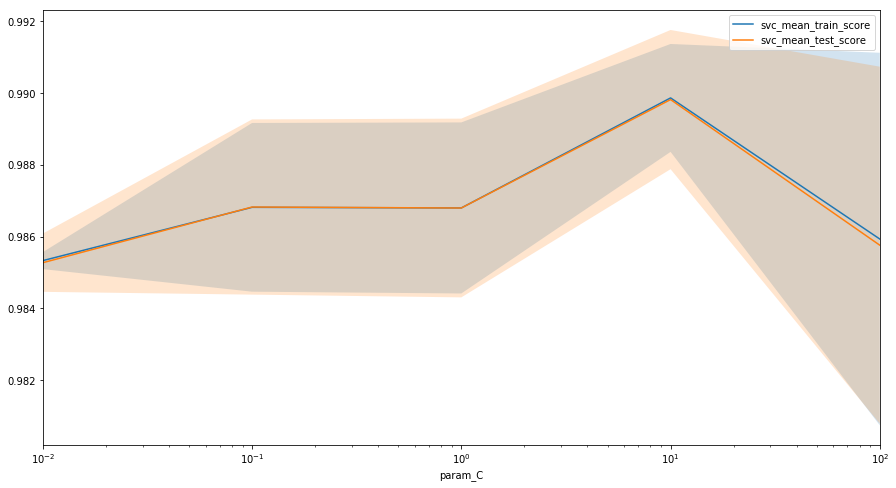

In [68]:
results_svc = pd.DataFrame(cv_results)
ax = results_svc.plot('param_C', 'mean_train_score', label='svc_mean_train_score', figsize=(15,8))
results_svc.plot('param_C', 'mean_test_score', ax=ax, label='svc_mean_test_score')
ax.fill_between(results_svc.param_C.astype(np.float),
                 results_svc['mean_train_score'] + results_svc['std_train_score'],
                 results_svc['mean_train_score'] - results_svc['std_train_score'], alpha=0.2)
ax.fill_between(results_svc.param_C.astype(np.float),
                 results_svc['mean_test_score'] + results_svc['std_test_score'],
                 results_svc['mean_test_score'] - results_svc['std_test_score'], alpha=0.2)

plt.legend(loc='best')
plt.xscale("log")

##### <a> 4.1.7 Random forest classifier </a>

In [ ]:
def grid_search_cv(X, y):
    """ Function to do grid search for random forest classifier """
    param_grid = {'bootstrap': [True],
                  'min_samples_leaf': [2, 4, 8],
                  'min_samples_split': [2, 4, 8, 16],
                  'n_estimators': [100, 150, 200, 300]}
    clf = RandomForestClassifier(random_state = 42, class_weight='balanced')
    rf_cv = GridSearchCV(estimator = clf, param_grid = param_grid, cv=3, n_jobs=-1, verbose=2, return_train_score=True)
    rf_cv.fit(X,y)
    return rf_cv.best_params_, rf_cv.best_score_, rf_cv.best_estimator_, rf_cv.cv_results_

In [ ]:
start_time = time.time()
best_params, best_score, best_model, cv_results = grid_search_cv(X_train_dummies, y_train_bin)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 195.1min


In [ ]:
print('best mean cross-validation score: {:.3f}'.format(best_score))
print('best params: {}'.format(best_params))
print('test-set score: {:.3f}'.format(best_model.score(X_test_dummies, y_test_bin)))

In [ ]:
y_pred = best_model.predict(X_test_dummies)
count_misclassified = (y_test_bin['attack_bin_group'] != y_pred).sum()
accuracy = metrics.accuracy_score(y_test_bin['attack_bin_group'], y_pred)
print('misclassified datapoints: {} \n'.format(count_misclassified))
print('accuracy: {:.3f} \n '.format(accuracy))
print('the classification report: \n {}'.format(classification_report(y_test_bin['attack_bin_group'], y_pred)))

In [ ]:
cm = confusion_matrix(y_test_bin['attack_bin_group'],y_pred)
obs = np.sum(cm)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['normal','anomaly']
plt.title('normal or anomaly confusion matrix')
plt.ylabel('true label')
plt.xlabel('predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str('{:.2f}'.format(cm[i][j]/obs*100)) + "%")
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_pred, y_test_bin['attack_bin_group'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
results_rf = pd.DataFrame(cv_results)
results_rf['param_msl_mss_n'] = results_rf['param_min_samples_leaf'].astype(str) \
                                + '_' + results_rf['param_min_samples_split'].astype(str)\
                                + '_' + results_rf['param_n_estimators'].astype(str)
ax = results_rf.plot('param_msl_mss_n', 'mean_train_score', label='rf_mean_train_score', figsize=(15,8))
results_rf.plot('param_msl_mss_n', 'mean_test_score', ax=ax, label='rf_mean_test_score')
ax.fill_between(results_rf.param_msl_mss_n.astype(np.float),
                 results_rf['mean_train_score'] + results_rf['std_train_score'],
                 results_rf['mean_train_score'] - results_rf['std_train_score'], alpha=0.2)
ax.fill_between(results_rf.param_msl_mss_n.astype(np.float),
                 results_rf['mean_test_score'] + results_rf['std_test_score'],
                 results_rf['mean_test_score'] - results_rf['std_test_score'], alpha=0.2)
plt.legend(loc='best')

In [ ]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_train_dummies.columns)
feat_importances.nlargest(20).plot(kind='barh', title='rf feature importance')

#### <a> 4.2 Feature selection (binary classification) </a>

##### <a> 4.2.1 Feature selection based on previous RF model </a>

The twenty most important features as per the random classifier is plotted in the figure. Lets retrain the random forest again with top 10 important features but with larger space for hyper parameters to search.

In [ ]:
imp_features = feat_importances.nlargest(10).index.to_list()

In [ ]:
def grid_search_cv(X, y):
    """ Function to do grid search for random forest classifier """
    param_grid = {'bootstrap': [True],
                  'min_samples_leaf': [2, 4, 8, 16],
                  'min_samples_split': [2, 4, 8, 16, 32],
                  'n_estimators': [100, 150, 200, 300, 400]}
    clf = RandomForestClassifier(random_state = 42, class_weight='balanced')
    rf_cv = GridSearchCV(estimator = clf, param_grid = param_grid, cv=3, n_jobs=-1, verbose=2,
                         return_train_score=True)
    rf_cv.fit(X,y)
    return rf_cv.best_params_, rf_cv.best_score_, rf_cv.best_estimator_, rf_cv.cv_results_

In [ ]:
start_time = time.time()
best_params, best_score, best_model, cv_results = grid_search_cv(X_train_dummies[imp_features], y_train_bin)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print('best mean cross-validation score: {:.3f}'.format(best_score))
print('best params: {}'.format(best_params))
print('test-set score: {:.3f}'.format(best_model.score(X_test_dummies[imp_features], y_test_bin)))

In [ ]:
y_pred = best_model.predict(X_test_dummies[imp_features])
count_misclassified = (y_test_bin['attack_bin_group'] != y_pred).sum()
accuracy = metrics.accuracy_score(y_test_bin['attack_bin_group'], y_pred)
print('misclassified datapoints: {} \n'.format(count_misclassified))
print('accuracy: {:.3f} \n '.format(accuracy))
print('the classification report: \n {}'.format(classification_report(y_test_bin['attack_bin_group'], y_pred)))

In [ ]:
cm = confusion_matrix(y_test_bin['attack_bin_group'],y_pred)
obs = np.sum(cm)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['normal','anomaly']
plt.title('normal or anomaly confusion matrix')
plt.ylabel('true label')
plt.xlabel('predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str('{:.2f}'.format(cm[i][j]/obs*100)) + "%")
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_pred, y_test_bin['attack_bin_group'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
results_rf_imp = pd.DataFrame(cv_results)
results_rf_imp['param_msl_mss_n'] = results_rf_imp['param_min_samples_leaf'].astype(str) \
                                + '_' + results_rf_imp['param_min_samples_split'].astype(str)\
                                + '_' + results_rf_imp['param_n_estimators'].astype(str)
ax = results_rf_imp.plot('param_msl_mss_n', 'mean_train_score', label='rf_mean_train_score', figsize=(15,8))
results_rf_imp.plot('param_msl_mss_n', 'mean_test_score', ax=ax, label='rf_mean_test_score')
ax.fill_between(results_rf_imp.param_msl_mss_n.astype(np.float),
                 results_rf_imp['mean_train_score'] + results_rf_imp['std_train_score'],
                 results_rf_imp['mean_train_score'] - results_rf_imp['std_train_score'], alpha=0.2)
ax.fill_between(results_rf_imp.param_msl_mss_n.astype(np.float),
                 results_rf_imp['mean_test_score'] + results_rf_imp['std_test_score'],
                 results_rf_imp['mean_test_score'] - results_rf_imp['std_test_score'], alpha=0.2)
plt.legend(loc='best')

In [ ]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_train_dummies[imp_features].columns)
feat_importances.nlargest(20).plot(kind='barh', title='rf feature importance')

The performance of the random forest classifier with just 10 features is same as the model (random forest) considering all features.

##### <a> 4.2.2 Feature selection based on model </a>

The most important features are selected using logistic regression model and then applied the random forest classifier on both train and test data set.

In [ ]:
select_model = SelectFromModel(LogisticRegression(solver='lbfgs',
                                                  random_state=42,
                                                  max_iter=1000, 
                                                  class_weight='balanced',
                                                  verbose=0))
select_model.fit(X_train_dummies, y_train_bin)
selected_feat= X_train_dummies.columns[(select_model.get_support())]

In [ ]:
def grid_search_cv(X, y):
    """ Function to do grid search for random forest classifier """
    param_grid = {'bootstrap': [True],
                  'min_samples_leaf': [2, 4, 8],
                  'min_samples_split': [2, 4, 8],
                  'n_estimators': [100, 150, 200]}
    clf = RandomForestClassifier(random_state = 42, class_weight='balanced')
    rf_cv = GridSearchCV(estimator = clf, param_grid = param_grid, cv=3, n_jobs=-1, verbose=2,
                         return_train_score=True)
    rf_cv.fit(X,y)
    return rf_cv.best_params_, rf_cv.best_score_, rf_cv.best_estimator_, rf_cv.cv_results_

In [ ]:
start_time = time.time()
best_params, best_score, best_model, cv_results = grid_search_cv(X_train_dummies[selected_feat], y_train_bin)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print('best mean cross-validation score: {:.3f}'.format(best_score))
print('best params: {}'.format(best_params))
print('test-set score: {:.3f}'.format(best_model.score(X_test_dummies[selected_feat], y_test_bin)))

In [ ]:
y_pred = best_model.predict(X_test_dummies[selected_feat])
count_misclassified = (y_test_bin['attack_bin_group'] != y_pred).sum()
accuracy = metrics.accuracy_score(y_test_bin['attack_bin_group'], y_pred)
print('misclassified datapoints: {} \n'.format(count_misclassified))
print('accuracy: {:.3f} \n '.format(accuracy))
print('the classification report: \n {}'.format(classification_report(y_test_bin['attack_bin_group'], y_pred)))

In [ ]:
cm = confusion_matrix(y_test_bin['attack_bin_group'],y_pred)
obs = np.sum(cm)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['normal','anomaly']
plt.title('normal or anomaly confusion matrix')
plt.ylabel('true label')
plt.xlabel('predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str('{:.2f}'.format(cm[i][j]/obs*100)) + "%")
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_pred, y_test_bin['attack_bin_group'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
results_rf_sel_feat = pd.DataFrame(cv_results)
results_rf_sel_feat['param_msl_mss_n'] = results_rf_sel_feat['param_min_samples_leaf'].astype(str) \
                                + '_' + results_rf_sel_feat['param_min_samples_split'].astype(str)\
                                + '_' + results_rf_sel_feat['param_n_estimators'].astype(str)
ax = results_rf_sel_feat.plot('param_msl_mss_n', 'mean_train_score', label='rf_mean_train_score', figsize=(15,8))
results_rf_sel_feat.plot('param_msl_mss_n', 'mean_test_score', ax=ax, label='rf_mean_test_score')
ax.fill_between(results_rf_sel_feat.param_msl_mss_n.astype(np.float),
                 results_rf_sel_feat['mean_train_score'] + results_rf_sel_feat['std_train_score'],
                 results_rf_sel_feat['mean_train_score'] - results_rf_sel_feat['std_train_score'], alpha=0.2)
ax.fill_between(results_rf_sel_feat.param_msl_mss_n.astype(np.float),
                 results_rf_sel_feat['mean_test_score'] + results_rf_sel_feat['std_test_score'],
                 results_rf_sel_feat['mean_test_score'] - results_rf_sel_feat['std_test_score'], alpha=0.2)
plt.legend(loc='best')

In [ ]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_train_dummies[selected_feat].columns)
feat_importances.nlargest(20).plot(kind='barh', title='rf feature importance')

The performance of the random forest classifier with selected features is same as the model (random forest) considering all features.

#### <a> 4.3 Multi label classification </a>

We will use the lower level target feature "attack_group" as label and try out classification models.

##### <a> 4.3.1 Prepare train test data set </a>

Here, we consider the column "attack_feature" as target columnc

In [ ]:
exclude_features = ['num_outbound_cmds', 'rerror_rate', 'srv_rerror_rate', 'serror_rate', 'srv_serror_rate',
                    'dst_host_serror_rate', 'dst_host_rerror_rate', 'is_host_login','dst_host_same_srv_rate',
                    'num_root', 'service','attack']
include_features = ['X_service']

X_features = [feature for feature in cnames if feature not in exclude_features] + include_features
y_feature = ['attack_group']

X_train = df_train[X_features]
y_train = df_train[y_feature]
X_test = df_test[X_features]
y_test = df_test[y_feature]

numerical_features = X_train.select_dtypes(exclude=['object','category','bool']).columns.tolist()

##### <a> 4.3.2 Encode target feature </a>

In [ ]:
le = preprocessing.LabelEncoder()
y_train_label = le.fit(y_train['attack_group']).transform(y_train['attack_group'])
y_test_label = le.fit(y_test['attack_group']).transform(y_test['attack_group'])

##### <a> 4.3.3 Scale the numerical features </a>

Scaling the training and test features to improve the performance and also brings the feature scale further close to each other.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features]= scaler.transform(X_test[numerical_features])

##### <a> 4.3.4 Create dummies for categorical features </a>

In [ ]:
X_train_dummies= pd.get_dummies(X_train)
X_test_dummies= pd.get_dummies(X_test)
X_train_dummies.head()

##### <a> 4.3.5 Generic functions </a>

In [ ]:
def generic_grid_search_cv(X, y, algo, param_grid):
    """ function to do grid search for selected model """
    if algo.lower() == 'logistic':
        clf = LogisticRegression(multi_class='ovr', solver='lbfgs', 
                                 random_state=42, max_iter=1000,
                                 class_weight='balanced', verbose=0)
        logreg_cv = GridSearchCV(clf, param_grid, cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                                 return_train_score=True)
        logreg_cv.fit(X,y)
        
        return logreg_cv.best_params_, logreg_cv.best_score_, logreg_cv.best_estimator_, logreg_cv.cv_results_
    elif algo.lower() == 'svc':
        clf = LinearSVC(multi_class='ovr', verbose=0, max_iter=1000, class_weight='balanced')
        svc_cv = GridSearchCV(clf, param_grid, cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                              return_train_score=True)
        svc_cv.fit(X,y)
        
        return svc_cv.best_params_, svc_cv.best_score_, svc_cv.best_estimator_, svc_cv.cv_results_
    elif algo.lower() == 'rf':
        clf = RandomForestClassifier(random_state = 42, class_weight='balanced')
        rf_cv = GridSearchCV(estimator = clf, param_grid = param_grid, cv=3, n_jobs=-1, verbose=2,
                             return_train_score=True)
        rf_cv.fit(X,y)
        return rf_cv.best_params_, rf_cv.best_score_, rf_cv.best_estimator_, rf_cv.cv_results_

In [ ]:
def generic_confusion_matrix(y_test, y_pred):
    """ create generic confusion matrix """
    return pd.DataFrame(data=confusion_matrix(y_test, y_pred),
                        columns=Counter(sorted(list(le.inverse_transform(y_test)))).keys(),
                        index=Counter(sorted(list(le.inverse_transform(y_test)))).keys())

In [ ]:
def generic_plot_feature_importance(best_model):
    """ plot feature importance """
    fig, axes = plt.subplots(1, 5, figsize=(15, 15))
    for ax, coef, classname in zip(axes, best_model.coef_, Counter(sorted(list(le.inverse_transform(y_test_label)))).keys()):
        ax.barh(range(len(X_test_dummies.columns)), coef, height=.5, color=plt.cm.bwr_r(np.sign(coef)))
        ax.set_xlim(best_model.coef_.min() - .1, best_model.coef_.max() + .1)

        ax.set_title(classname)
        ax.set_frame_on(False)
        ax.set_yticks(())

    axes[0].set_yticks(range(len(X_test_dummies.columns)))
    axes[0].set_yticklabels(X_test_dummies.columns)
    plt.tight_layout()

In [ ]:
def generic_plot_train_test_scores(cv_results_in, algo):
    """ plot train test scores """
    results = pd.DataFrame(cv_results_in)
    if algo.lower() != 'rf':
        ax = results.plot('param_C', 'mean_train_score', label='svc_mean_train_score', figsize=(15,8))
        results.plot('param_C', 'mean_test_score', ax=ax, label='svc_mean_test_score')
        ax.fill_between(results.param_C.astype(np.float),
                        results['mean_train_score'] + results['std_train_score'],
                        results['mean_train_score'] - results['std_train_score'], alpha=0.2)
        ax.fill_between(results.param_C.astype(np.float),
                        results['mean_test_score'] + results['std_test_score'],
                        results['mean_test_score'] - results['std_test_score'], alpha=0.2)
        plt.xscale("log")
    else:
        results['param_msl_mss_n'] = results['param_min_samples_leaf'].astype(str) \
                                     + '_' + results['param_min_samples_split'].astype(str)\
                                     + '_' + results['param_n_estimators'].astype(str)
        ax = results.plot('param_msl_mss_n', 'mean_train_score', label='rf_mean_train_score', figsize=(15,8))
        results.plot('param_msl_mss_n', 'mean_test_score', ax=ax, label='rf_mean_test_score')
        ax.fill_between(results.param_msl_mss_n.astype(np.float),
                         results['mean_train_score'] + results['std_train_score'],
                         results['mean_train_score'] - results['std_train_score'], alpha=0.2)
        ax.fill_between(results.param_msl_mss_n.astype(np.float),
                         results['mean_test_score'] + results['std_test_score'],
                         results['mean_test_score'] - results['std_test_score'], alpha=0.2)
    plt.legend(loc='best')

In [ ]:
# X_train_dummies = X_train_dummies.head(20000)
# y_train_label = y_train_label[:20000]
# X_test_dummies = X_test_dummies.head(20000)
# y_test_label = y_test_label[:20000]

##### <a> 4.8.6 Logistic Regression </a>

Model criteria

- ovr (one vs rest)
- balanced weights
- kfold stratification

In [ ]:
start_time = time.time()
param_grid = {"C":[0.01, 0.1, 1, 10, 100, 1000]}
best_params, best_score, best_model, cv_results = generic_grid_search_cv(X_train_dummies,  y_train_label,
                                                                          'logistic', param_grid)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print('best mean cross-validation score: {:.3f}'.format(best_score))
print('best params: {}'.format(best_params))
print('test-set score: {:.3f}'.format(best_model.score(X_test_dummies, y_test_label)))

In [ ]:
y_pred = best_model.predict(X_test_dummies)
count_misclassified = (y_test_label!= y_pred).sum()
accuracy = metrics.accuracy_score(y_test_label, y_pred)
print('misclassified datapoints: {} \n'.format(count_misclassified))
print('accuracy: {:.3f} \n '.format(accuracy))
print('the classification report: \n {}'.format(classification_report(y_test_label, y_pred)))

 - The classes are imbalanced, therefore we use weighed average metric.
 - We use weighted f1-score so, we can easily compare with other classifiers such as LinearSVC. 

In [ ]:
generic_confusion_matrix(y_test_label, y_pred)

In [ ]:
generic_plot_feature_importance(best_model)

In [ ]:
generic_plot_train_test_scores(cv_results, 'logistic')

##### <a> 4.8.6 Linear SVC </a>

Model criteria

- ovr (one vs rest)
- balanced weights
- kfold stratification

In [ ]:
start_time = time.time()
param_grid = {"C":[0.01, 0.1, 1, 10, 100, 1000]}
best_params, best_score, best_model, cv_results = generic_grid_search_cv(X_train_dummies,  y_train_label,
                                                                          'svc', param_grid)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print('best mean cross-validation score: {:.3f}'.format(best_score))
print('best params: {}'.format(best_params))
print('test-set score: {:.3f}'.format(best_model.score(X_test_dummies, y_test_label)))

In [ ]:
y_pred = best_model.predict(X_test_dummies)
count_misclassified = (y_test_label!= y_pred).sum()
accuracy = metrics.accuracy_score(y_test_label, y_pred)
print('misclassified datapoints: {} \n'.format(count_misclassified))
print('accuracy: {:.3f} \n '.format(accuracy))
print('the classification report: \n {}'.format(classification_report(y_test_label, y_pred)))

 - The classes are imbalanced, therefore we use weighed average metric.
 - We use weighted f1-score so, we can easily compare with other classifiers. 

In [ ]:
generic_confusion_matrix(y_test_label, y_pred)

In [ ]:
generic_plot_feature_importance(best_model)

In [ ]:
generic_plot_train_test_scores(cv_results, 'svc')

##### <a> 4.8.6 Random forest classifier </a>

Model criteria

- balanced weights
- kfold stratification

In [ ]:
start_time = time.time()
param_grid = {'bootstrap': [True],
              'min_samples_leaf': [2, 4, 8],
              'min_samples_split': [2,4, 8],
              'n_estimators': [100, 150, 200]
             }
best_params, best_score, best_model, cv_results = generic_grid_search_cv(X_train_dummies,  y_train_label,
                                                                          'rf', param_grid)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print('best mean cross-validation score: {:.3f}'.format(best_score))
print('best params: {}'.format(best_params))
print('test-set score: {:.3f}'.format(best_model.score(X_test_dummies, y_test_label)))

In [ ]:
y_pred = best_model.predict(X_test_dummies)
count_misclassified = (y_test_label!= y_pred).sum()
accuracy = metrics.accuracy_score(y_test_label, y_pred)
print('misclassified datapoints: {} \n'.format(count_misclassified))
print('accuracy: {:.3f} \n '.format(accuracy))
print('the classification report: \n {}'.format(classification_report(y_test_label, y_pred)))

 - The classes are imbalanced, therefore we use weighed average metric.
 - We use weighted f1-score so, we can easily compare with other classifiers. 

In [ ]:
generic_confusion_matrix(y_test_label, y_pred)

In [ ]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_train_dummies.columns)
feat_importances.nlargest(20).plot(kind='barh', title='rf feature importance')

In [ ]:
generic_plot_train_test_scores(cv_results, 'rf')

### <a> 5. Conclusion </a>

#### <a> 5.1 Binary classification </a>

#### <a> 5.1 Multiclass classification </a>